# Project Pipeline

Lucovica Schaerf, Antònio Mendes, Jaël Kortekaas

Large part of our code is used from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Introduction

This file contains the the preprocessing pipeline to our project. 
As a first step we are importing the data and filtering out all the songs that
we don't need for our analysis. Secondly, we will implement the 'standard' 
pipeline and, once we obtain the most common words per each album, author, year
(...) we will move to another file to do the clustering and topic analysis.

## Import

In [8]:
from pathlib import Path
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk.collocations import BigramAssocMeasures
import nltk
import re
import string
import gensim
import spacy
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter

import matplotlib.pyplot as plt

plot_dir = Path("./figures")
data_dir = Path("./data")

In [2]:
songs = []

with open('./data/lyrics.csv', 'r', encoding="utf-8") as infile:
    songs = pd.read_csv(infile)
    
print(songs.columns)

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')


In [3]:
artists = ['bruce-springsteen', 'elliot-smith', 'black-sabbath', 'deep-purple', 'david-bowie']

david_bowie = songs[songs[u'artist'] == 'david-bowie']
black_sabbath = songs[songs[u'artist'] == 'black-sabbath']
bruce_springsteen = songs[songs[u'artist'] == 'bruce-springsteen']
elliot_smith = songs[songs[u'artist'] == 'elliot-smith']
deep_purple = songs[songs[u'artist'] == 'deep-purple']

lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)
lyrics = lyrics.dropna()
lyrics

,index,song,year,artist,genre,lyrics
116793,116793,if-i-m-dreaming-my-life,2009,david-bowie,Rock,VERSE (there)\nWas she never there/here?\nWas ...
116794,116794,seven,2009,david-bowie,Rock,I forgot what my father said\nI forgot what he...
116795,116795,i-can-t-read,2009,david-bowie,Rock,I can't read and I can't write down\nI don't k...
116796,116796,thursday-s-child,2009,david-bowie,Rock,All of my life I've tried so hard\nDoing my be...
116797,116797,survive,2009,david-bowie,Rock,"Oh, my\nNaked eyes\nI should have kept you\nI ..."
...,...,...,...,...,...,...
67509,67509,child-in-time,1972,deep-purple,Rock,Sweet child in time\nYou'll see the line\nThe ...
67510,67510,deep-purple-overture,2015,deep-purple,Rock,"Good golly, said little miss molly\nWhen she w..."
67517,67517,paint-it-black,2015,deep-purple,Rock,"I see a red door and I want it painted black,\..."
67523,67523,anyone-s-daughter,2014,deep-purple,Rock,"Well, I stood under your bedroom window, throw..."


## Processing Pipeline

In [103]:
stop_words = stopwords.words('english')
stop_words.extend(['oh', 'yeah', 'hey', 'doo', 'oo', 'uh', 'la', 'verse', 'chorus', 'bridge', 'x2', "'m", 'da', 'ooh', 'aaaahh', 'ooo', 'duh', 'whop', 'u', 'ah', 'na', 'whoa', 'ai', "n't", 'wa', 'gon', "'ll", 'gon', "'d", "'re", "'ve", "'em", "'", 'ca', 'ha', 'wo', 'wir', 'wan', 'doe', 'well', 'sha', 'ya', 'ta', "'cause", "`"]) # filter out common meaningless words/sounds and words describing song structure

The preprocessing pipeline we decided to implement includes the following steps:
- filtering out stopwords, puntuation, sounds typical from songs
- lemmatizing
- adding the most common bigrams

In [155]:
wnl = WordNetLemmatizer()
bigram_measures = BigramAssocMeasures()
un2wn_mapping = {"VERB" : wn.VERB, "NOUN" : wn.NOUN, "ADJ" : wn.ADJ, "ADV" : wn.ADV}

def convertTuple(tup): 
    str =  '_'.join(tup) 
    return str
  
def simple_preprocess(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyricslist = [re.sub('\-', '', str(lyric)) for lyric in lyrics['lyrics'].tolist()] # take out all hyphens that often connect meaningless words/sounds to these stopwords can be filtered out later
    lyricslist = [re.sub('[\.\,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation
    lyricslist = [word_tokenize(lyric.lower()) for lyric in lyricslist]
    finder = []
    for i,lyric in enumerate(lyricslist):
        for j,tup in enumerate(nltk.pos_tag(lyric, tagset="universal")):
            token = "-".join([tup[0], tup[1]])
            if token.split("-")[-1] in un2wn_mapping.keys():
                lyricslist[i][j] = "-".join([wnl.lemmatize(str(token.split("-")[0]), pos = un2wn_mapping[token.split("-")[-1]]), token.split("-")[-1]])
            else:
                lyricslist[i][j] = "-".join([wnl.lemmatize(str(token.split("-")[0])),token.split("-")[-1]]) 
        lyricslist[i] = [word for word in lyric if word.split("-")[0] not in stop_words]
        finder.append(BigramCollocationFinder.from_words(lyric))
        finder[i] = finder[i].nbest(bigram_measures.pmi, 20)
        finder[i] = [convertTuple(x) for x in finder[i]] #need to append the two words back together
        lyricslist[i] = [word for word in lyric if word.split("-")[-1] == "NOUN"]
        lyricslist[i] = lyricslist[i] + finder[i]
    lyrics['bag_of_words'] = lyricslist


simple_preprocess(lyrics)
example = lyrics['bag_of_words'][116793]
example

['verse-NOUN',
 'air-NOUN',
 'time-NOUN',
 'flower-NOUN',
 'gallery-NOUN',
 'hymn-NOUN',
 'night-NOUN',
 'chorus-NOUN',
 'time-NOUN',
 'day-NOUN',
 'light-NOUN',
 'life-NOUN',
 'time-NOUN',
 'chance-NOUN',
 'mother-NOUN',
 'father-NOUN',
 'step-NOUN',
 'time-NOUN',
 'verse-NOUN',
 'chorus-NOUN',
 'life-NOUN',
 'life-NOUN',
 'life-NOUN',
 'dreaming-NOUN',
 'life-NOUN',
 'life-NOUN',
 'repeat-NOUN',
 'life-NOUN',
 'dreaming-NOUN',
 'life-NOUN',
 'come-VERB_to-PRT',
 'fade-VERB_now-ADV',
 'father-NOUN_step-NOUN',
 'flower-NOUN_so-ADV',
 'gallery-NOUN_with-ADP',
 'hymn-NOUN_of-ADP',
 'it-PRON_air-NOUN',
 'just-ADV_one-NUM',
 'live-VERB_chance-NOUN',
 'mother-NOUN_sigh-VERB',
 'never-ADV_there/here-DET',
 'night-NOUN_sing-VERB',
 'of-ADP_night-NOUN',
 'one-NUM_live-VERB',
 'sing-VERB_come-VERB',
 'so-ADV_from-ADP',
 'step-NOUN_aside-ADV',
 'to-PRT_me-PRON',
 'x2-ADP_second-ADJ',
 'chance-NOUN_when-ADV']

In [156]:
#count how many times a word appears --> give a document
#lyrics['bag_of_words']

list_BOWlyrics = [[]]
for lyric in lyrics['bag_of_words']:
    list_BOWlyrics += [lyric]

lyrics_dictionary = corpora.Dictionary(list_BOWlyrics)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 27851


In [157]:
print(dict(itertools.islice(lyrics_dictionary.token2id.items(), 12)))
print("word with id 8:", lyrics_dictionary[8])
print("frequency of token 8:", lyrics_dictionary.dfs[8])

{'air-NOUN': 0, 'chance-NOUN': 1, 'chance-NOUN_when-ADV': 2, 'chorus-NOUN': 3, 'come-VERB_to-PRT': 4, 'day-NOUN': 5, 'dreaming-NOUN': 6, 'fade-VERB_now-ADV': 7, 'father-NOUN': 8, 'father-NOUN_step-NOUN': 9, 'flower-NOUN': 10, 'flower-NOUN_so-ADV': 11}
word with id 8: father-NOUN
frequency of token 8: 43


In [158]:
# Filter out words that occur in less than 5 documents, or more than 70% of the documents.
lyrics_dictionary.filter_extremes(no_below=2, no_above=0.3)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 8343


In [159]:
# Bag-of-words representation of the documents
lyrics_bow_corpus = [lyrics_dictionary.doc2bow(d) for d in list_BOWlyrics]

In [160]:
# the BOW representation of the first document
print(lyrics_bow_corpus[1][:50])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 8), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2)]


In [161]:
# which words (and how often) appear in the first document?
for i, freq in sorted(lyrics_bow_corpus[1], key=itemgetter(1), reverse=True)[:15]:
    print(lyrics_dictionary[i], "-->", freq)
print("...")

life-NOUN --> 8
chorus-NOUN --> 2
dreaming-NOUN --> 2
verse-NOUN --> 2
air-NOUN --> 1
chance-NOUN --> 1
come-VERB_to-PRT --> 1
day-NOUN --> 1
father-NOUN --> 1
flower-NOUN --> 1
gallery-NOUN --> 1
hymn-NOUN --> 1
just-ADV_one-NUM --> 1
light-NOUN --> 1
mother-NOUN --> 1
...


In [162]:
lyrics_ldamodel = models.ldamodel.LdaModel(lyrics_bow_corpus, num_topics=10, id2word = lyrics_dictionary, passes=25)

In [163]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
lyrics_ldamodel.show_topics(formatted=False, num_words=15)

[(0,
  [('da-NOUN', 0.038209487),
   ('baby-NOUN', 0.023037024),
   ('somebody-NOUN', 0.018633816),
   ('love-NOUN', 0.015927922),
   ('whoa-NOUN', 0.015855681),
   ('yeah-NOUN', 0.0112876445),
   ('man-NOUN', 0.011008566),
   ('way-NOUN', 0.009823215),
   ('eye-NOUN', 0.0093977805),
   ('boot-NOUN', 0.0052265404),
   ('mind-NOUN', 0.0051820143),
   ('style-NOUN', 0.0051124296),
   ('hey-NOUN', 0.0050349906),
   ('fool-NOUN', 0.0050342097),
   ('world-NOUN', 0.004933279)]),
 (1,
  [('love-NOUN', 0.055522867),
   ('thing-NOUN', 0.025577333),
   ('way-NOUN', 0.0125366775),
   ('fire-NOUN', 0.01136626),
   ('life-NOUN', 0.011214286),
   ('baby-NOUN', 0.009950187),
   ('ground-NOUN', 0.009311527),
   ('day-NOUN', 0.008648619),
   ('eye-NOUN', 0.007957869),
   ('home-NOUN', 0.007954745),
   ('heart-NOUN', 0.007518441),
   ('man-NOUN', 0.0073767006),
   ('sound-NOUN', 0.0073655765),
   ('boy-NOUN', 0.00577361),
   ('world-NOUN', 0.0056224666)]),
 (2,
  [('train-NOUN', 0.0198593),
   ('home-N

In [ ]:
from collections import defaultdict

import nltk.corpus
import numpy as np
import matplotlib.pyplot as plt
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values
doc2topics_bowie = np.zeros((len(bowie_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bowie_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_bowie[di, ti] = v
  

sabbath_song_titles = lyrics["song"].values[570:779]
doc2topics_sabbath = np.zeros((len(sabbath_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(sabbath_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_sabbath[di, ti] = v

             
bruce_song_titles = lyrics["song"].values[779:1288]
doc2topics_bruce = np.zeros((len(bruce_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(bruce_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_bruce[di, ti] = v

        
elliot_song_titles = lyrics["song"].values[1288:1324]
doc2topics_elliot = np.zeros((len(elliot_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(elliot_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_elliot[di, ti] = v



deep_song_titles = lyrics["song"].values[1324:1551]
doc2topics_deep = np.zeros((len(deep_song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(deep_song_titles)):
        break
    for ti, v in doc_topics:
        doc2topics_deep[di, ti] = v

Text(0, 0.5, 'probability of topic')

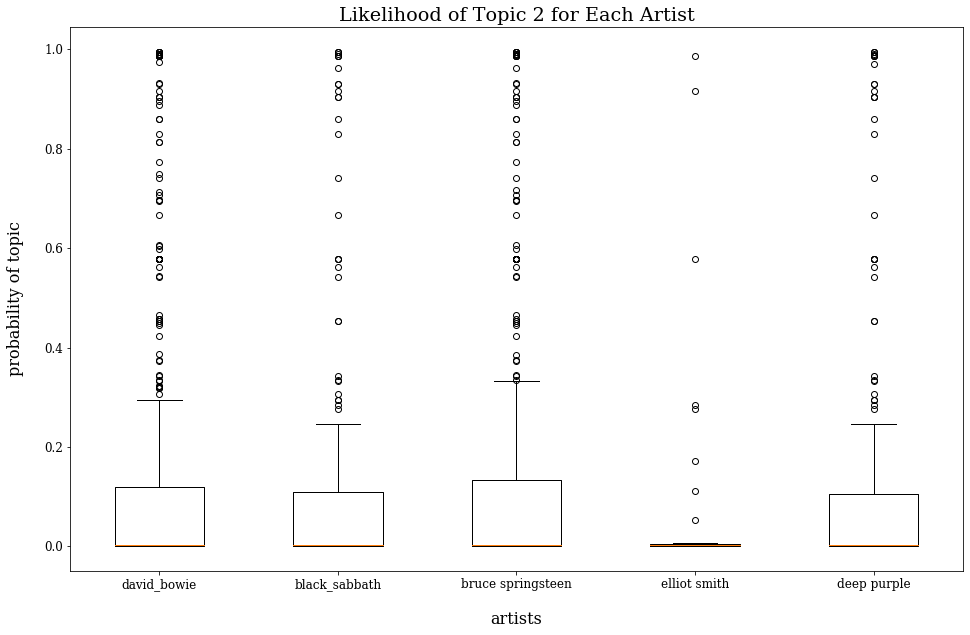

In [27]:
#Method 3
# again please add the labels for which one is topic 2
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(16, 10))


artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

plt.boxplot([doc2topics_bowie[:,1],
             doc2topics_sabbath[:,1],
             doc2topics_bruce[:,1], 
             doc2topics_elliot[:,1], 
             doc2topics_deep[:,1]], 
            meanline = True,
            notch = False,
            labels = artist_labels
           )

plt.title("Likelihood of Topic 2 for Each Artist")
plt.xlabel("artists",fontdict=font, labelpad =20)
plt.ylabel("probability of topic",fontdict=font, labelpad =20)

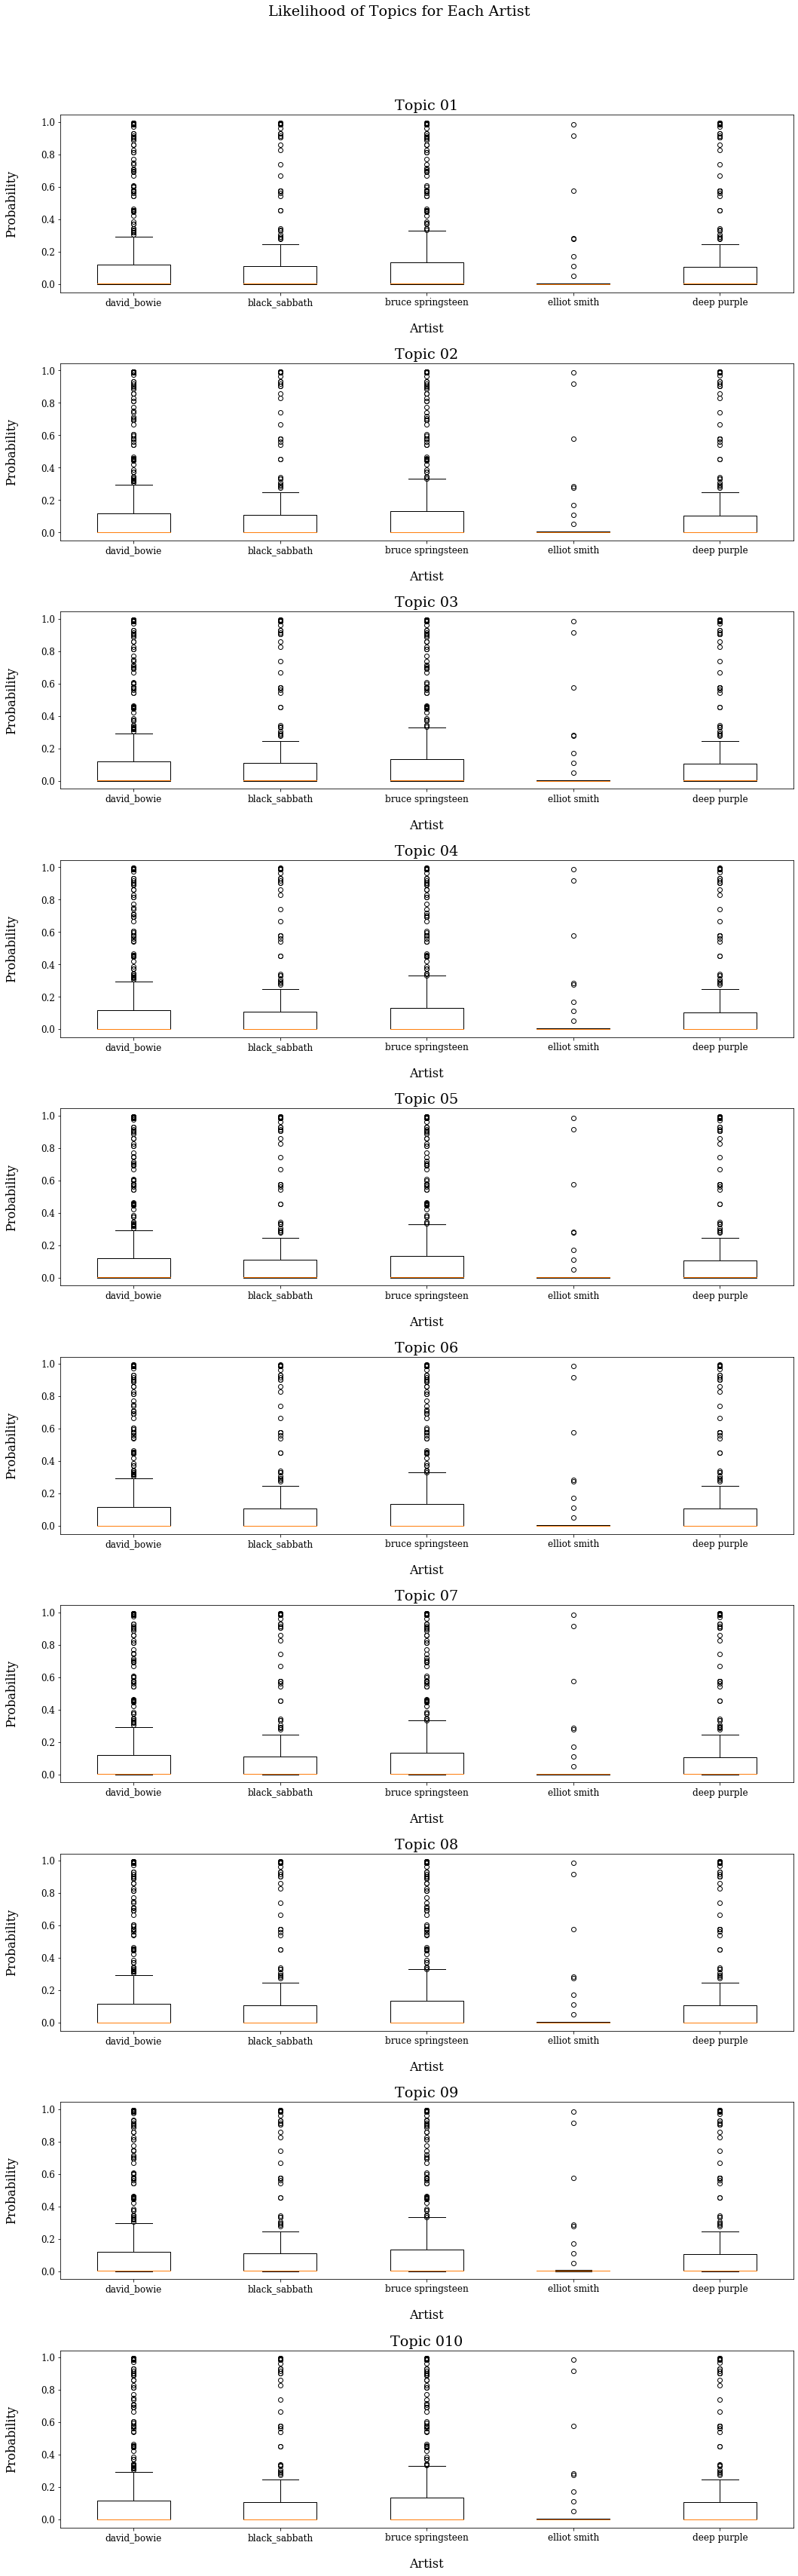

In [29]:
#the above is not necessary, cram it to this and add the name of the topics
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)


font = {'family': 'serif',
        'weight': 'normal',
        'size': 16,
        }

matplotlib.rc('font', **font)

fig, ax = plt.subplots(nrows = lda_model.num_topics, sharex=False, sharey=False)
fig.set_figheight(50)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4) 

artist_labels = ["david_bowie",
                "black_sabbath",
                "bruce springsteen",
                "elliot smith",
                "deep purple"]

for i in range(0, lda_model.num_topics):
    ax[i].boxplot([doc2topics_bowie[:,1],
                     doc2topics_sabbath[:,1],
                     doc2topics_bruce[:,1], 
                     doc2topics_elliot[:,1], 
                     doc2topics_deep[:,1]], 
                    meanline = True,
                    notch = False,
                    labels = artist_labels)
    ax[i].set_title("Topic 0%d" %(i+1))
    ax[i].set_ylabel("Probability", labelpad=30, fontdict=font)
    ax[i].set_xlabel("Artist", labelpad = 20, fontdict=font)

fig.suptitle("Likelihood of Topics for Each Artist")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("boxplot.png")

In [30]:
song_titles = lyrics["song"].values[:570]
bowie_song_titles = lyrics.query("artist == 'david-bowie'")["song"].values[:10]
print(len(song_titles))
doc2topics_all = np.zeros((len(song_titles), lda_model.num_topics))

for di, doc_topics in enumerate(lda_model.get_document_topics(lyrics_bow_corpus, minimum_probability = 0)):
    if(di >= len(song_titles)):
        break
    for ti, v in doc_topics:

        doc2topics_all[di, ti] = v

570


(36, 10)


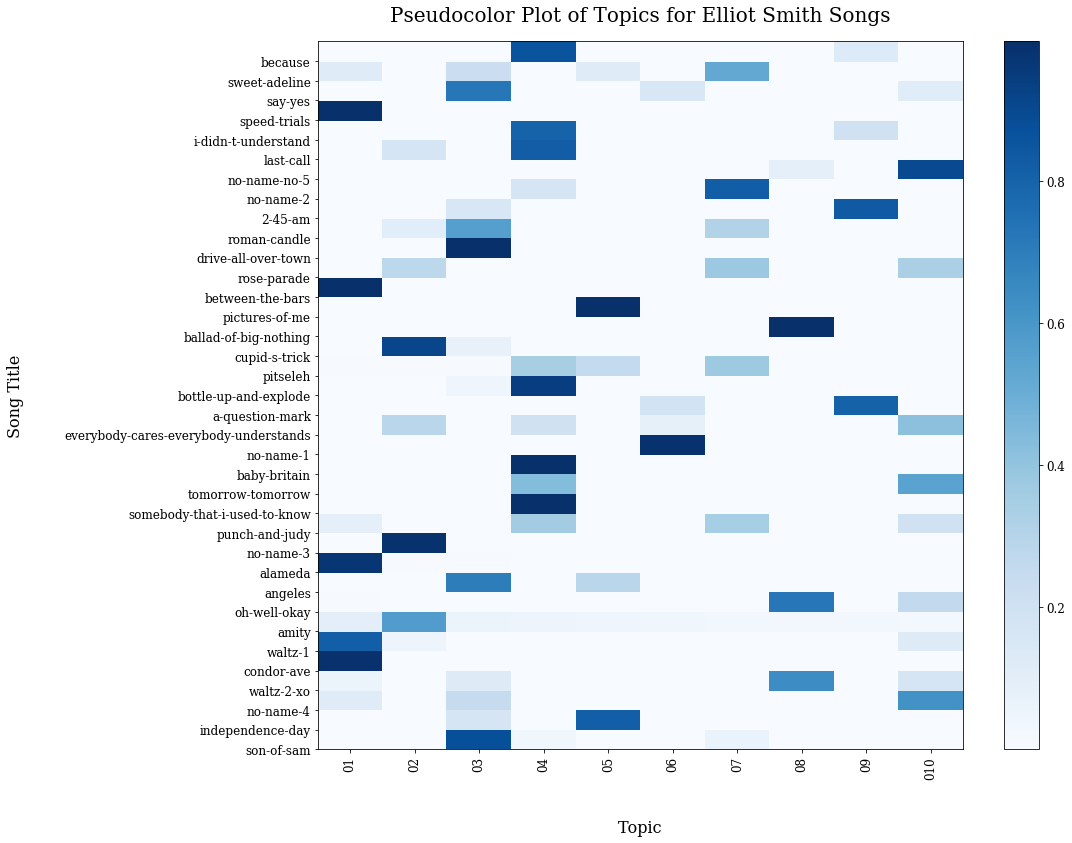

In [31]:
#Method 4
title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

print(doc2topics_elliot.shape)

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_elliot, norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_elliot.shape[0]), elliot_song_titles)

plt.xticks(np.arange(doc2topics_elliot.shape[1])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for Elliot Smith Songs", pad=20, fontdict=title_font)
plt.tight_layout()  # fixes margins
plt.show()

fig.savefig("pcolor_elliot.png")

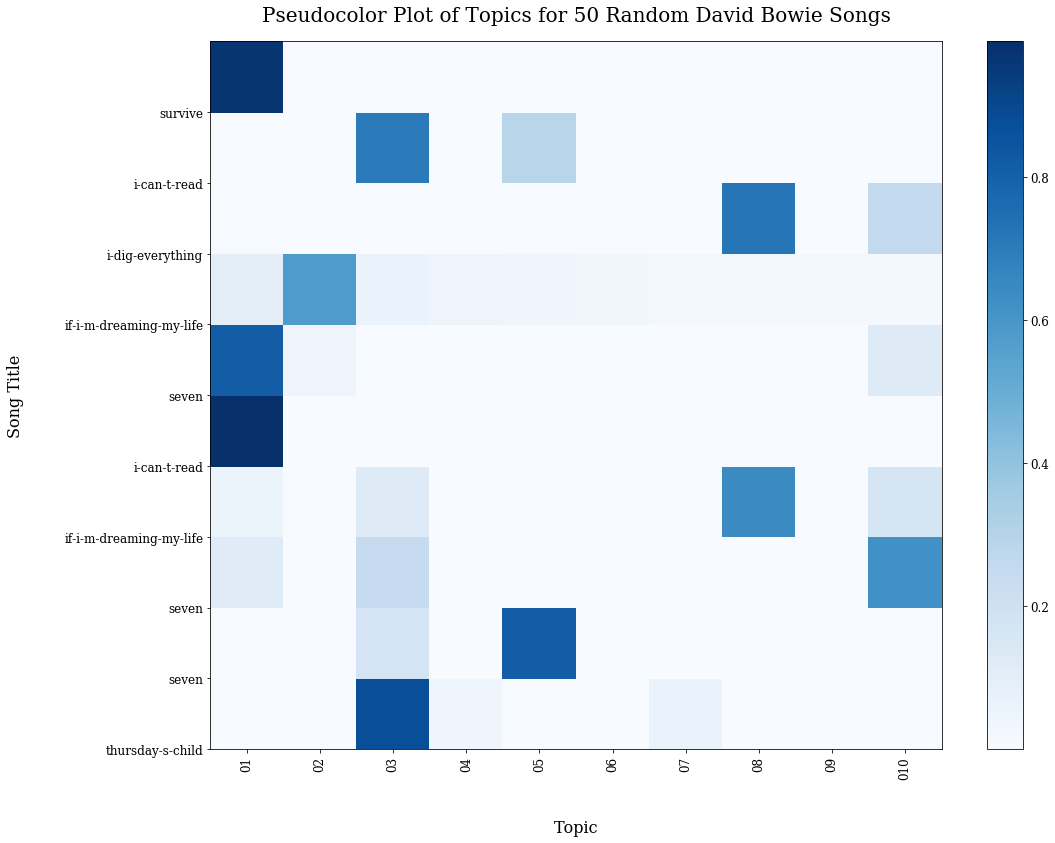

In [32]:
bowie_50_song_titles = np.random.choice(bowie_song_titles, size = 50)

sample_indices_bowie = np.asarray(np.nonzero(np.in1d(bowie_song_titles,bowie_50_song_titles)))

doc2topics_bowie_50 = doc2topics_bowie[sample_indices_bowie]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bowie_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bowie_50.shape[1]), bowie_50_song_titles)

plt.xticks(np.arange(doc2topics_bowie_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random David Bowie Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bowie.png")

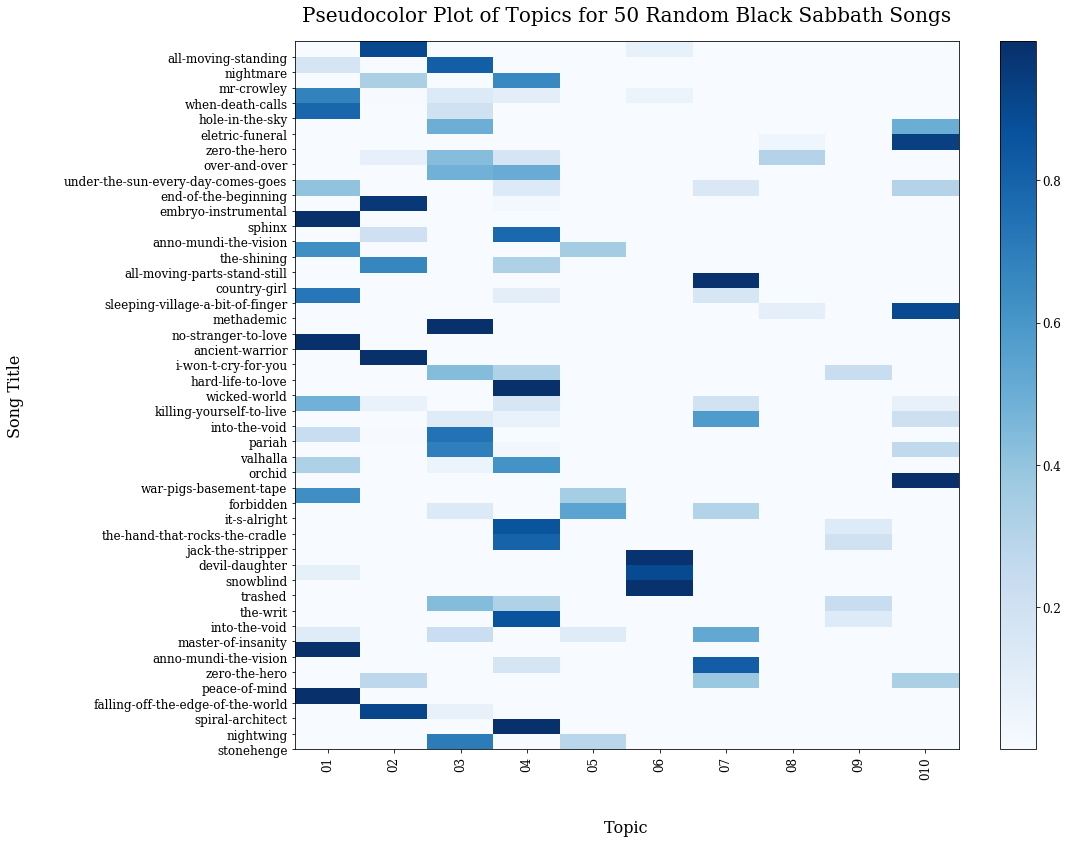

In [33]:
sabbath_50_song_titles = np.random.choice(sabbath_song_titles, size = 50)

sample_indices_sabbath = np.asarray(np.nonzero(np.in1d(sabbath_song_titles,sabbath_50_song_titles)))

doc2topics_sabbath_50 = doc2topics_sabbath[sample_indices_sabbath]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_sabbath_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_sabbath_50.shape[1]), sabbath_50_song_titles)

plt.xticks(np.arange(doc2topics_sabbath_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Black Sabbath Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_sabbath.png")

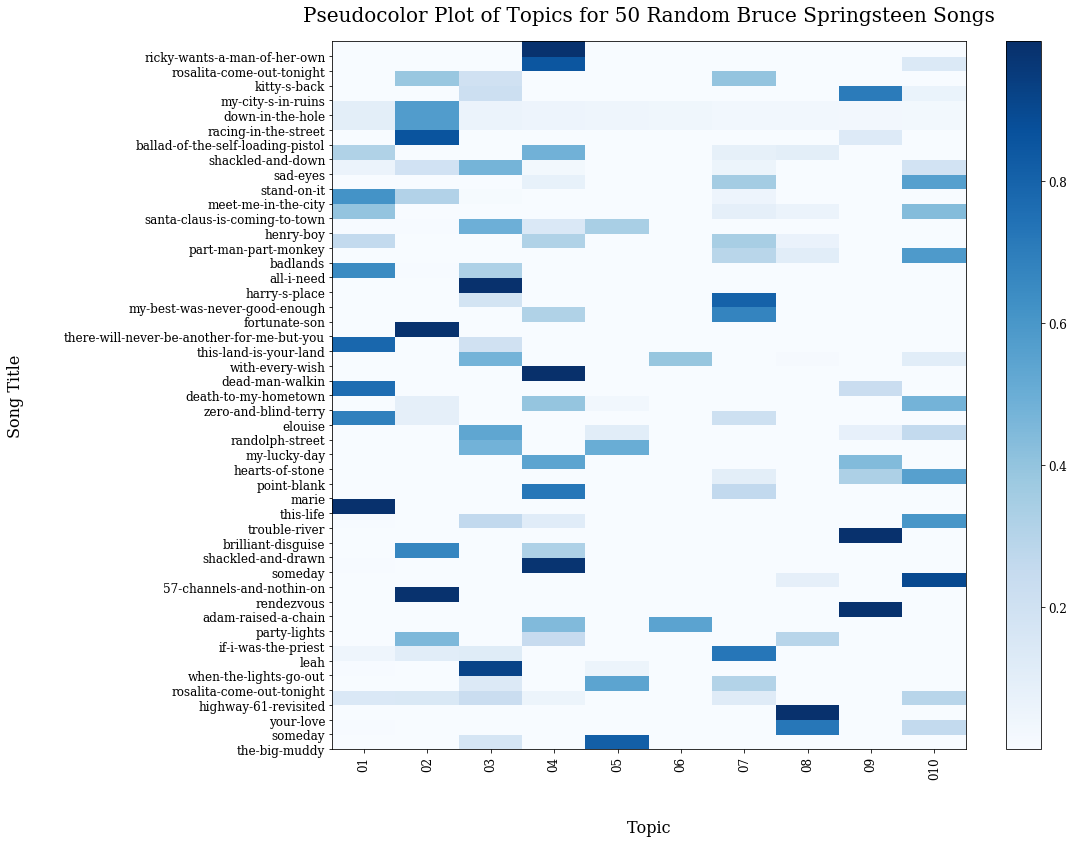

In [34]:
bruce_50_song_titles = np.random.choice(bruce_song_titles, size = 50)

sample_indices_bruce = np.asarray(np.nonzero(np.in1d(bruce_song_titles,bruce_50_song_titles)))

doc2topics_bruce_50 = doc2topics_bruce[sample_indices_bruce]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_bruce_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_bruce_50.shape[1]), bruce_50_song_titles)

plt.xticks(np.arange(doc2topics_bruce_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Bruce Springsteen Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_bruce.png")

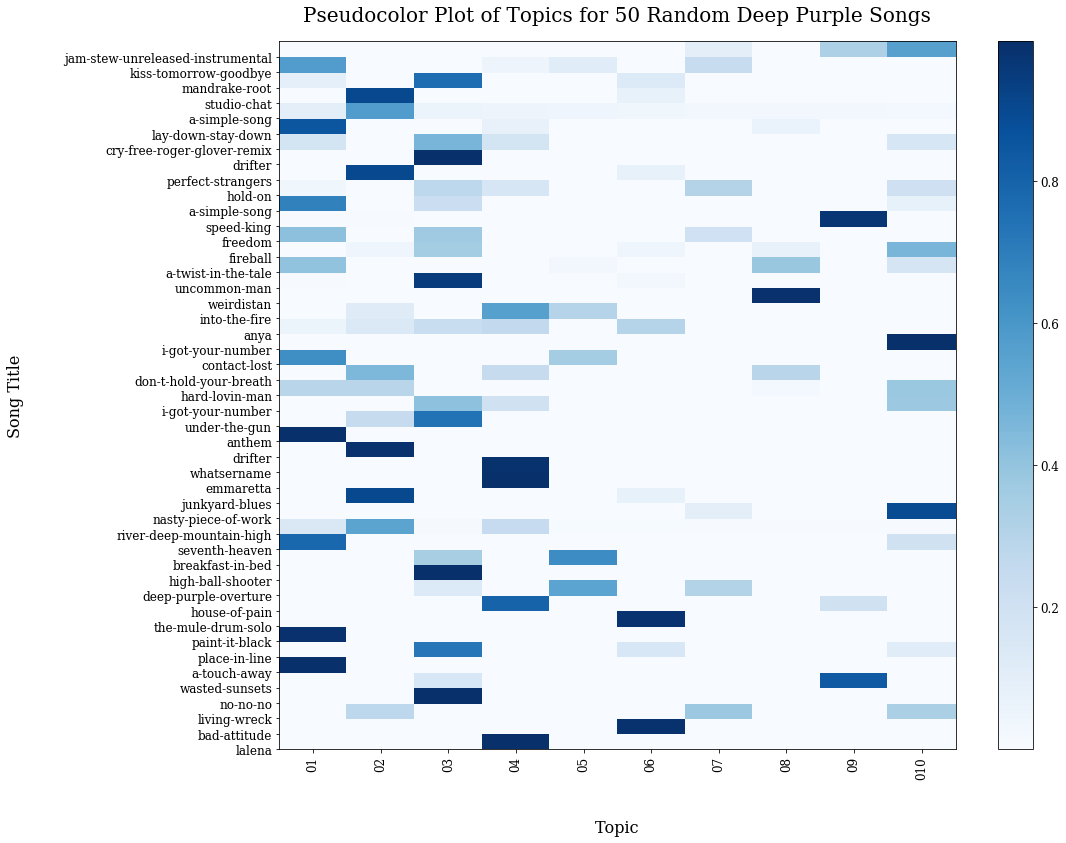

In [35]:
deep_50_song_titles = np.random.choice(deep_song_titles, size = 50)

sample_indices_deep = np.asarray(np.nonzero(np.in1d(deep_song_titles,deep_50_song_titles)))

doc2topics_deep_50 = doc2topics_deep[sample_indices_deep]

title_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 20}

label_font = {'family': 'serif',
        'weight': 'normal',
        'fontsize': 16}

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics_deep_50[0], norm=None, cmap ='Blues')
plt.yticks(np.arange(doc2topics_deep_50.shape[1]), deep_50_song_titles)

plt.xticks(np.arange(doc2topics_deep_50.shape[2])+0.5, ["0"+str(n+1) for n in range(lda_model.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.ylabel("Song Title", labelpad = 40, fontdict=label_font)
plt.xlabel("Topic", labelpad = 40, fontdict=label_font)
plt.title("Pseudocolor Plot of Topics for 50 Random Deep Purple Songs", pad=20, fontdict=title_font)
plt.tight_layout()
plt.show()

fig.savefig("pcolor_deep.png")

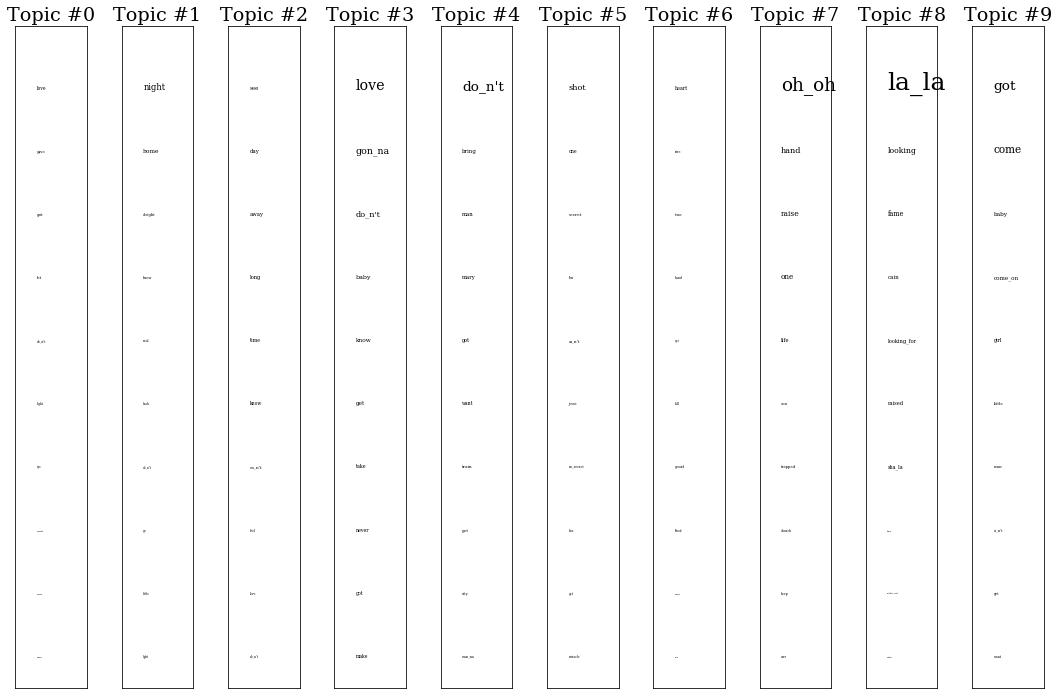

In [43]:
#Method 5
fig = plt.figure(figsize=(15, 10))

num_top_words = 10

topic2top_words = dict(lda_model.show_topics(formatted=False, num_words = num_top_words))
fontsize_base = 25 / max([w[0][1] for w in topic2top_words.values()]) # font size for word with largest share in corpus

for topic, words_shares in topic2top_words.items():
    plt.subplot(1, lda_model.num_topics, topic + 1)
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(topic))
    for i, (word, share) in enumerate(words_shares):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)
        
plt.tight_layout()

# Exploring Different Cardinalities
This section contains 3 new models on different levels of analysis. These are:
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

The purpose of this additional models is to provide some new insights and topics that are specific to that level of analysis.
For instance, if a topic only appears in the last model, then we can conclude that it is rather specific to one single album.

### Common topics in all songs per artist
Now we are interested in identifying what are the common topics of each artists

In [60]:
from IPython.display import display

list_BOWlyrics_per_artist = [] 
lyrics_dictionary_per_artist = []

for i,artist in enumerate(artists):
    lyrics_of_artist = []
    for lyric in lyrics[lyrics['artist'] == artist]['bag_of_words']:
        lyrics_of_artist += [lyric]
    list_BOWlyrics_per_artist.append(lyrics_of_artist)

for i,artist in enumerate(artists):
    lyrics_dictionary_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_artist[i]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_artist[i]))

Number of unique tokens: 6153
Number of unique tokens: 987
Number of unique tokens: 2352
Number of unique tokens: 2889
Number of unique tokens: 6056


In [61]:
lyrics_bow_corpus_per_artist = []

for i,artist in enumerate(artists):
    lyrics_bow_corpus_per_artist.append([lyrics_dictionary_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_artist[i]])
    

In [62]:
lyrics_ldamodel_per_artist = []

for i,artist in enumerate(artists):
    lyrics_ldamodel_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_artist[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_artist[i],\
                                                               passes= 25))


In [63]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,artist in enumerate(artists):
    print('\n', artist, ':\n')
    display(lyrics_ldamodel_per_artist[i].show_topics(formatted=False, num_words=15))


 bruce-springsteen :



[(0,
  [('get', 0.017034713),
   ('wan_na', 0.014804906),
   ('girl', 0.014683709),
   ('little', 0.01069774),
   ('got', 0.010588281),
   ('baby', 0.010294583),
   ('da_da', 0.009260865),
   ('tonight', 0.00864074),
   ('shooter', 0.008543812),
   ('night', 0.008206291),
   ('band', 0.008011003),
   ('love', 0.007643618),
   ('jeannie', 0.0075416123),
   ('need', 0.0069081387),
   ("do_n't", 0.0068588825)]),
 (1,
  [('come', 0.020302383),
   ('train', 0.016385537),
   ('little', 0.0140780695),
   ('this_train', 0.01154879),
   ('girl', 0.011023937),
   ('heart', 0.010792635),
   ('get', 0.009184931),
   ('time', 0.008906266),
   ("do_n't", 0.008781888),
   ('let', 0.00871842),
   ('take', 0.008547972),
   ('freehold', 0.008328892),
   ('got', 0.008211176),
   ('little_girl', 0.007976936),
   ('baby', 0.0076005594)]),
 (2,
  [('baby', 0.025762903),
   ('want', 0.016620735),
   ('come', 0.014984268),
   ('got', 0.014214627),
   ('man', 0.0134652415),
   ("ai_n't", 0.012181611),
   ('com


 elliot-smith :



[(0,
  [('never', 0.029174559),
   ('tell', 0.024841527),
   ('gon_na', 0.020765303),
   ('home', 0.016653802),
   ('wanted', 0.016650924),
   ('wake', 0.016650835),
   ('sick', 0.0166463),
   ('would', 0.016629796),
   ('oblivion', 0.014597914),
   ('come', 0.014591915),
   ('know', 0.014535925),
   ('town', 0.012541564),
   ('good', 0.012541365),
   ('come_on', 0.010485755),
   ('anyhow', 0.010485502)]),
 (1,
  [("wo_n't", 0.016909273),
   ('follow', 0.013560849),
   ('parade', 0.013560832),
   ('make', 0.013538752),
   ('never', 0.013355729),
   ('rose', 0.011886611),
   ('thing', 0.010205164),
   ('keep', 0.008538388),
   ('away', 0.008531833),
   ('bottle', 0.008529557),
   ('light', 0.008513032),
   ('love', 0.0068645445),
   ('drink', 0.00686423),
   ('people', 0.0068642125),
   ('everyone', 0.0068639466)]),
 (2,
  [('around', 0.014790891),
   ("ca_n't", 0.014450097),
   ('apart', 0.012827758),
   ('morning', 0.012826529),
   ('someone', 0.012524906),
   ('back', 0.010519588),
 


 black-sabbath :



[(0,
  [("do_n't", 0.026476385),
   ('see', 0.02359805),
   ('got', 0.018639138),
   ('woman', 0.016504591),
   ('evil', 0.016198974),
   ('away', 0.015621438),
   ('rock', 0.012149407),
   ('game', 0.010521264),
   ('play', 0.010521192),
   ('know', 0.010294012),
   ('life', 0.010110517),
   ('get', 0.009989635),
   ('evil_woman', 0.009865655),
   ('got_ta', 0.00953843),
   ('eye', 0.008745517)]),
 (1,
  [('angel', 0.020772975),
   ('death', 0.016877247),
   ('god', 0.01581634),
   ('dead', 0.014151457),
   ('man', 0.013188292),
   ('psycho', 0.011586525),
   ('love', 0.009807553),
   ('light', 0.009606515),
   ("ca_n't", 0.008479425),
   ('sin', 0.0084141055),
   ("do_n't", 0.0077918097),
   ('neon', 0.0077425144),
   ('power', 0.0072203344),
   ('take', 0.00706957),
   ('thing', 0.0070566097)]),
 (2,
  [('die', 0.011042783),
   ('world', 0.009437932),
   ('turn', 0.009307254),
   ('night', 0.009208198),
   ('young', 0.009014435),
   ('today', 0.008260949),
   ('looking', 0.007768231


 deep-purple :



[(0,
  [("do_n't", 0.039297655),
   ('want', 0.016911792),
   ('black', 0.016855542),
   ('way', 0.016030913),
   ('know', 0.013782316),
   ('long', 0.010628378),
   ('night', 0.010378272),
   ('got', 0.010350488),
   ('feel', 0.009378149),
   ('day', 0.008286243),
   ('right', 0.0076598465),
   ('find', 0.0074506733),
   ('see', 0.007367344),
   ("wo_n't", 0.007195275),
   ('need', 0.0068951626)]),
 (1,
  [('time', 0.02310171),
   ('never', 0.0155147435),
   ('go', 0.014712205),
   ('around', 0.01412697),
   ('see', 0.014088627),
   ('way', 0.012646013),
   ('work', 0.012118228),
   ('fall', 0.010095763),
   ('line', 0.00993924),
   ('right', 0.009847128),
   ('would', 0.009098306),
   ('make', 0.008783795),
   ('back', 0.008682736),
   ("ca_n't", 0.008344863),
   ('tell', 0.008238807)]),
 (2,
  [('got', 0.02499913),
   ('love', 0.020386007),
   ('gon_na', 0.016031316),
   ('get', 0.014391299),
   ('time', 0.012793746),
   ('never', 0.012140059),
   ('could', 0.011124889),
   ('baby',


 david-bowie :



[(0,
  [('fame', 0.019976405),
   ('love', 0.018210538),
   ('girl', 0.013365367),
   ('make', 0.010460274),
   ("do_n't", 0.010127732),
   ('god', 0.009835479),
   ('little', 0.009345811),
   ('city', 0.009245109),
   ('rather', 0.008464442),
   ("'d_rather", 0.008464209),
   ('day', 0.008073457),
   ('man', 0.0080531),
   ('fame_fame', 0.0078786705),
   ('baby', 0.007771773),
   ('get', 0.0072782733)]),
 (1,
  [('love', 0.019757196),
   ('little', 0.018116863),
   ('ba', 0.01354795),
   ('want', 0.009967084),
   ('day', 0.0095828045),
   ('go', 0.008447408),
   ('back', 0.008352616),
   ('young', 0.007658135),
   ('heaven', 0.0072802114),
   ('home', 0.007276591),
   ('people', 0.006648594),
   ('got', 0.0064515546),
   ('ba_ba', 0.0061517456),
   ('genie', 0.0061512925),
   ('jean', 0.0061512897)]),
 (2,
  [('take', 0.02029118),
   ('sex', 0.018671686),
   ('let', 0.01576043),
   ('got', 0.014938862),
   ('love', 0.01287794),
   ('dance', 0.012866775),
   ('right', 0.012821219),
   

### Common topics in all songs per year
Now we are interested in identifying what are the common topics of each year

In [64]:
years = list(lyrics['year'].unique())

In [66]:
list_BOWlyrics_per_year = []
lyrics_dictionary_per_year = []

for k,year in enumerate(years): 
    lyrics_of_year = []
    for lyric in lyrics[lyrics['year'] == year]['bag_of_words']:
        lyrics_of_year += [lyric]
    list_BOWlyrics_per_year.append(lyrics_of_year)
    
for k,year in enumerate(years):
    lyrics_dictionary_per_year.append(corpora.Dictionary(list_BOWlyrics_per_year[k]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year[k]))

Number of unique tokens: 778
Number of unique tokens: 1962
Number of unique tokens: 539
Number of unique tokens: 1869
Number of unique tokens: 563
Number of unique tokens: 410
Number of unique tokens: 1750
Number of unique tokens: 915
Number of unique tokens: 750
Number of unique tokens: 7400
Number of unique tokens: 712
Number of unique tokens: 360
Number of unique tokens: 567
Number of unique tokens: 606
Number of unique tokens: 406
Number of unique tokens: 709
Number of unique tokens: 1921
Number of unique tokens: 680
Number of unique tokens: 577
Number of unique tokens: 804
Number of unique tokens: 757
Number of unique tokens: 2327
Number of unique tokens: 636
Number of unique tokens: 398
Number of unique tokens: 245
Number of unique tokens: 702
Number of unique tokens: 417
Number of unique tokens: 263
Number of unique tokens: 2001
Number of unique tokens: 704
Number of unique tokens: 430
Number of unique tokens: 582
Number of unique tokens: 268


In [67]:
lyrics_bow_corpus_per_year = []

for i,year in enumerate(years):
    lyrics_bow_corpus_per_year.append([lyrics_dictionary_per_year[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year[i]])
    

In [68]:
lyrics_ldamodel_per_year = []

for i,year in enumerate(years):
    lyrics_ldamodel_per_year.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_year[i],\
                                                               passes= 25))


In [69]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year[i].show_topics(formatted=False, num_words=15))


 2009 :



[(0,
  [('hear', 0.060315233),
   ('pete', 0.048880506),
   ('outlaw', 0.034588937),
   ("ca_n't", 0.020298379),
   ('read', 0.011721403),
   ('get', 0.011721194),
   ('right', 0.008862417),
   ('shit', 0.008862389),
   ('rode', 0.008861666),
   ('pony', 0.008861485),
   ('got', 0.0060042194),
   ('say', 0.006003743),
   ('go', 0.006003651),
   ('night', 0.006003612),
   ('money', 0.0060035945)]),
 (1,
  [('survive', 0.037025798),
   ('boy', 0.03396223),
   ('back', 0.030903364),
   ('eye', 0.021725941),
   ('town', 0.0217237),
   ('know', 0.018665895),
   ('naked', 0.018665798),
   ('never', 0.018665714),
   ('tomorrow', 0.0125453845),
   ('night', 0.012545122),
   ('got', 0.012544843),
   ('give', 0.009485871),
   ('man', 0.009485564),
   ('long', 0.009485312),
   ('chick', 0.00948512)]),
 (2,
  [('life', 0.08016923),
   ('dreaming', 0.05357706),
   ('ohoh', 0.022582188),
   ('next', 0.022581814),
   ('time', 0.01815808),
   ('night', 0.018154634),
   ('wrong', 0.018154297),
   ('awa


 2007 :



[(0,
  [('underground', 0.039539196),
   ('daddy', 0.02544307),
   ('wan_na', 0.01628072),
   ('live', 0.015576106),
   ('live_underground', 0.015576024),
   ('la_la', 0.015575204),
   ('sister', 0.014166363),
   ('take', 0.011707822),
   ('get', 0.011347477),
   ('light', 0.010525126),
   ('know', 0.008952058),
   ('one', 0.0087189125),
   ('ah_ha', 0.008528014),
   ('got', 0.00833239),
   ('thing', 0.007944036)]),
 (1,
  [('jane', 0.0154533805),
   ('time', 0.01456178),
   ('bop', 0.011614825),
   ('sweet', 0.011613966),
   ("do_n't", 0.010645301),
   ('last', 0.009678828),
   ('die', 0.00967248),
   ('major_tom', 0.008735424),
   ('tom', 0.008735116),
   ('major', 0.008735024),
   ('mistake', 0.008734232),
   ('long', 0.008677028),
   ('lala', 0.007775184),
   ('fashion', 0.0077751437),
   ('la_la', 0.007775122)]),
 (2,
  [('dance', 0.057493363),
   ('let', 0.04177089),
   ('magic', 0.027233073),
   ('jump', 0.019929193),
   ('young', 0.01575463),
   ('baby', 0.01471201),
   ('die',


 1980 :



[(0,
  [('oh_oh', 0.0018644931),
   ('running', 0.0018612621),
   ('thing', 0.0018601404),
   ('done', 0.0018592894),
   ('monster', 0.0018586718),
   ('major_tom', 0.0018586435),
   ('scary', 0.0018586036),
   ("do_n't", 0.0018582724),
   ('tom', 0.0018581701),
   ('keep', 0.0018581287),
   ('major', 0.001857873),
   ('scared', 0.0018577549),
   ('better', 0.0018577218),
   ('creep', 0.0018576386),
   ('mess', 0.0018576112)]),
 (1,
  [('million', 0.0018628559),
   ('dream', 0.001859006),
   ('broken', 0.0018588147),
   ('piece', 0.0018587583),
   ('love', 0.0018577029),
   ('say', 0.0018574891),
   ('young', 0.0018573254),
   ('ni', 0.0018571169),
   ('scar', 0.0018570002),
   ('back', 0.0018568855),
   ("do_n't", 0.0018567302),
   ('make', 0.0018566336),
   ('meet', 0.0018565367),
   ('away', 0.0018565004),
   ('nicer', 0.0018564882)]),
 (2,
  [('oh_oh', 0.0018661565),
   ('running', 0.0018622119),
   ('scared', 0.0018585977),
   ('scary', 0.0018583554),
   ('keep', 0.001858303),
   


 2013 :



[(0,
  [('got', 0.042689696),
   ("'d_rather", 0.031820208),
   ('rather', 0.031820193),
   ('face', 0.023631727),
   ('dancing', 0.017873047),
   ('saturday', 0.016606618),
   ('aah', 0.015338971),
   ('drivein', 0.015338901),
   ('high', 0.014071847),
   ('flying', 0.012804159),
   ('dom', 0.012803237),
   ('coming', 0.010274159),
   ('stormbringer', 0.009000554),
   ('yes', 0.009000525),
   ('sir', 0.009000346)]),
 (1,
  [('come', 0.019815959),
   ('come_on', 0.018615337),
   ("do_n't", 0.015190458),
   ('got', 0.014899332),
   ('gon_na', 0.014411151),
   ('want', 0.013414997),
   ('love', 0.012325664),
   ('need', 0.0123086255),
   ('night', 0.011324738),
   ('girl', 0.010736872),
   ('everything', 0.009866792),
   ('turn', 0.00943466),
   ('god', 0.009165404),
   ('way', 0.009112186),
   ('bless', 0.008814212)]),
 (2,
  [("'ve_been", 0.03534925),
   ('ever', 0.020270465),
   ('day', 0.016920045),
   ('know', 0.015245217),
   ('baby', 0.013570183),
   ('would', 0.013569949),
   ('l


 1974 :



[(0,
  [('doo_doo', 0.0017847988),
   ('rebel', 0.0017823393),
   ('know', 0.0017795361),
   ('face', 0.0017790571),
   ('could', 0.0017785296),
   ('dress', 0.0017785144),
   ('love', 0.001778436),
   ('dog', 0.0017782097),
   ('tramp', 0.0017780184),
   ('mess', 0.0017779275),
   ('torn', 0.0017778887),
   ('got', 0.0017777063),
   ('babe', 0.0017775955),
   ('want', 0.0017775671),
   ('doodoo', 0.0017775147)]),
 (1,
  [('rebel', 0.073486604),
   ('doo_doo', 0.07348607),
   ('know', 0.032885972),
   ('could', 0.028826557),
   ('mess', 0.028826278),
   ('face', 0.028825976),
   ('doodoo', 0.02476613),
   ('dress', 0.02476608),
   ('love', 0.024766076),
   ('torn', 0.020705938),
   ('eh', 0.016646061),
   ('got', 0.016646015),
   ('want', 0.016646),
   ('put', 0.016645946),
   ('babe', 0.016645879)]),
 (2,
  [('someone', 0.12776476),
   ('claim', 0.026060862),
   ('fool', 0.026060829),
   ('apollo', 0.02606077),
   ('brave', 0.026060717),
   ('follow', 0.026060712),
   ('shame', 0.0260


 1975 :



[(0,
  [('want', 0.002455145),
   ('american', 0.002454165),
   ('young', 0.0024532122),
   ('young_american', 0.0024529593),
   ('somebody', 0.0024490156),
   ("ai_n't", 0.0024448503),
   ('got', 0.0024432258),
   ('night', 0.002442623),
   ('somebody_somebody', 0.0024423029),
   ('soul', 0.0024413748),
   ('hand', 0.002441005),
   ('remember', 0.0024409026),
   ('right', 0.0024408642),
   ('took', 0.0024405387),
   ('baby', 0.002440533)]),
 (1,
  [('somebody', 0.09184987),
   ('young', 0.054501355),
   ('american', 0.051105943),
   ('young_american', 0.051105052),
   ('want', 0.049407635),
   ('somebody_somebody', 0.02903165),
   ('soul', 0.020543387),
   ('got', 0.018846639),
   ("ai_n't", 0.018846445),
   ('night', 0.013752276),
   ('oohooh', 0.013751821),
   ('hand', 0.012054608),
   ('shine', 0.012054149),
   ('right', 0.010356868),
   ('say', 0.01035642)]),
 (2,
  [('nothing', 0.16555506),
   ('gon_na', 0.13725434),
   ('change', 0.12782198),
   ('world', 0.0853718),
   ('univer


 2005 :



[(0,
  [('got', 0.021204613),
   ('bed', 0.015813865),
   ('tonight', 0.014194444),
   ('gon_na', 0.012442651),
   ('maria', 0.011519283),
   ('want', 0.011497298),
   ('man', 0.010690975),
   ('light', 0.010689487),
   ('eddie', 0.008937183),
   ('night', 0.008936937),
   ('work', 0.00885701),
   ('got_ta', 0.0071851327),
   ('one', 0.0071849637),
   ('sweet', 0.0071848603),
   ('right', 0.007184771)]),
 (1,
  [('leave', 0.01944276),
   ('today', 0.019442393),
   ('tomorrow', 0.017306214),
   ('gone', 0.01730576),
   ('time', 0.0130339665),
   ('stay', 0.013032974),
   ('little', 0.013032862),
   ('call', 0.013032821),
   ('sorrow', 0.013032562),
   ('alright', 0.0108965095),
   ('cup', 0.010896459),
   ('love', 0.008763993),
   ('day', 0.008760617),
   ('place', 0.0087599335),
   ('never', 0.008759894)]),
 (2,
  [('love', 0.038477007),
   ('modern_love', 0.02950973),
   ('modern', 0.029509725),
   ('god', 0.01640976),
   ('time', 0.01338793),
   ('china', 0.011285386),
   ('girl', 0.


 2010 :



[(0,
  [('midnight', 0.02066451),
   ('sister', 0.020663952),
   ('street', 0.018958025),
   ('da_da', 0.018957641),
   ('calling', 0.017248675),
   ('side', 0.015542042),
   ('come', 0.01554166),
   ('go', 0.013833921),
   ('come_on', 0.013833651),
   ('got', 0.012126383),
   ('hear', 0.012125306),
   ('tonight', 0.010418228),
   ('wishing', 0.010418186),
   ('see', 0.010417902),
   ('wrong', 0.010417725)]),
 (1,
  [('uhuhuh', 0.08757176),
   ('johnny', 0.074501514),
   ('afraid', 0.05271776),
   ('american', 0.048359875),
   ('uhuhuh_uh', 0.044003405),
   ('uhuh', 0.044003382),
   ('uh_uhuh', 0.044003297),
   ('america', 0.030933363),
   ('want', 0.02221965),
   ('chorusrepeat', 0.017862778),
   ("ca_n't", 0.009150157),
   ("can't", 0.009149215),
   ('help', 0.009149213),
   ('god', 0.009149097),
   ("do_n't", 0.0047926093)]),
 (2,
  [('night', 0.048206974),
   ('talk', 0.04343313),
   ('see', 0.029114772),
   ('asking', 0.02911458),
   ('yeah_yeah', 0.024341429),
   ('pay', 0.024341


 1973 :



[(0,
  [('baby', 0.03541509),
   ('detroit', 0.032162674),
   ('panic', 0.03216254),
   ('back', 0.024202913),
   ('would', 0.020445108),
   ('wish', 0.020250686),
   ('someone', 0.012604882),
   ('phone', 0.012420612),
   ('pretty', 0.012309444),
   ('autograph', 0.012309039),
   ('home', 0.012308988),
   ('know', 0.010295719),
   ('ran', 0.008519616),
   ('looked', 0.008481649),
   ('cry', 0.008338912)]),
 (1,
  [('back', 0.018481705),
   ('time', 0.018470604),
   ('star', 0.018465882),
   ('prettiest', 0.018465813),
   ('take', 0.013962034),
   ('moved', 0.013961935),
   ('day', 0.013961592),
   ('gone', 0.013961452),
   ('let', 0.013961406),
   ('thing', 0.01396136),
   ("did_n't", 0.013961312),
   ('good', 0.013961234),
   ('one', 0.0094603645),
   ('way', 0.0094582895),
   ('staying', 0.00945812)]),
 (2,
  [('love', 0.042470828),
   ('let', 0.032318573),
   ('jean', 0.02893413),
   ('jean_genie', 0.028933706),
   ('genie', 0.028933646),
   ('rosalyn', 0.023859067),
   ('night', 0


 2006 :



[(0,
  [('love', 0.027288016),
   ('baby', 0.024737636),
   ('got', 0.01987932),
   ('take', 0.018209735),
   ('come', 0.017894361),
   ('know', 0.013709664),
   ('girl', 0.011718388),
   ('make', 0.011592144),
   ("do_n't", 0.011419997),
   ('way', 0.010016156),
   ('little', 0.009848306),
   ('come_on', 0.009714001),
   ('let', 0.009494686),
   ('thing', 0.009141518),
   ('want', 0.008966355)]),
 (1,
  [('got', 0.024893524),
   ('know', 0.010494268),
   ("'ve_got", 0.00979798),
   ("do_n't", 0.009707136),
   ('say', 0.009100182),
   ('go', 0.00904481),
   ('want', 0.008813947),
   ('back', 0.008161661),
   ('give', 0.0069890236),
   ('hold', 0.006390539),
   ('time', 0.0055242702),
   ('right', 0.0051822765),
   ('see', 0.0050173732),
   ('day', 0.005011095),
   ('nothing', 0.004750535)]),
 (2,
  [('baby', 0.027935734),
   ('dance', 0.027740585),
   ('back', 0.017201466),
   ('magic', 0.015070462),
   ('oh_oh', 0.014663189),
   ('home', 0.0135450605),
   ('going', 0.010663351),
   ('


 1970 :



[(0,
  [("do_n't", 0.024492921),
   ('stay', 0.019690044),
   ('let', 0.019688997),
   ('night', 0.014890095),
   ('life', 0.0148885595),
   ('logic', 0.014887923),
   ('savior', 0.014887883),
   ('mind', 0.014887522),
   ('machine', 0.014887112),
   ('eye', 0.010086938),
   ('tree', 0.0100867255),
   ('silver', 0.010086706),
   ('say', 0.010085811),
   ("ca_n't", 0.010085797),
   ('gave', 0.010085333)]),
 (1,
  [('mind', 0.02762721),
   ('war', 0.027622815),
   ('burning', 0.017397897),
   ('death', 0.017392168),
   ('funeral', 0.017392013),
   ('electric', 0.017391887),
   ('mass', 0.013981951),
   ('body', 0.010574511),
   ('turn', 0.010573271),
   ('hide', 0.010573041),
   ('day', 0.010572652),
   ('people', 0.0105718635),
   ('power', 0.010571848),
   ('lord', 0.010571708),
   ('turning', 0.010571688)]),
 (2,
  [('zane', 0.113064),
   ('ouvre', 0.03793858),
   ('chien', 0.037938546),
   ('le', 0.037938453),
   ('ah_ah', 0.030425616),
   ('day', 0.022913406),
   ('quite', 0.0154015


 1984 :



[(0,
  [('boy', 0.12589233),
   ('big', 0.12589222),
   ('dancing', 0.09017815),
   ('embarrassing', 0.018749785),
   ('society', 0.018749777),
   ('football', 0.009821215),
   ('people', 0.009821215),
   ('mark', 0.009821213),
   ('floor', 0.009821213),
   ('team', 0.009821213),
   ('bout', 0.009821211),
   ('chew', 0.009821211),
   ('belief', 0.009821211),
   ('much', 0.009821211),
   ('dot', 0.00982121)]),
 (1,
  [('go', 0.0027782216),
   ('pray', 0.0027781886),
   ('loving', 0.0027781827),
   ('strangest', 0.002778159),
   ('alien', 0.0027781462),
   ('come', 0.002778116),
   ('twirl', 0.0027781026),
   ('tumble', 0.0027780693),
   ('thing', 0.0027780428),
   ('believing', 0.0027780058),
   ('break', 0.0027779932),
   ('cross', 0.002777974),
   ('torture', 0.002777967),
   ('time', 0.0027779515),
   ('land', 0.0027779487)]),
 (2,
  [('keep', 0.07535918),
   ('forgetting', 0.067896515),
   ("do_n't", 0.052976858),
   ('love', 0.052974507),
   ('no_more', 0.052974466),
   ("ca_n't", 


 2016 :



[(0,
  [("'d_rather", 0.08815966),
   ('rather', 0.08815963),
   ('high', 0.038986683),
   ('flying', 0.035474457),
   ('love', 0.021425841),
   ('done', 0.0214258),
   ('new', 0.017913684),
   ('lost', 0.014401229),
   ('men', 0.014400489),
   ('say', 0.010888665),
   ('hour', 0.010888599),
   ('head', 0.010888222),
   ('sand', 0.010888152),
   ('my_head', 0.010888108),
   ('gun', 0.010888081)]),
 (1,
  [("ca_n't", 0.05844282),
   ('judge', 0.04875536),
   ('looking', 0.045527037),
   ('time', 0.026153827),
   ('know', 0.026153328),
   ('burn', 0.026153114),
   ('book', 0.019696156),
   ('cover', 0.019696059),
   ('see', 0.01646719),
   ('one', 0.016467085),
   ('woman', 0.016467005),
   ('hear', 0.016466977),
   ('try', 0.013238197),
   ('people', 0.013238188),
   ('came', 0.013238129)]),
 (2,
  [('thing', 0.051111232),
   ('boy', 0.043083422),
   ('sweet', 0.018999295),
   ('sweet_thing', 0.018999295),
   ('want', 0.01899915),
   ('make', 0.016323319),
   ('cheap', 0.01632329),
   (


 1971 :



[(0,
  [('come', 0.0016578475),
   ('could', 0.0016559474),
   ('ay', 0.0016558619),
   ('time', 0.0016556971),
   ('away', 0.0016556196),
   ('face', 0.0016537524),
   ('free', 0.0016537288),
   ('please', 0.001653485),
   ('strange', 0.001653418),
   ('change', 0.0016529692),
   ('chchchanges', 0.0016527661),
   ('turn', 0.0016526519),
   ('thought', 0.0016526352),
   ('old', 0.0016525445),
   ("do_n't", 0.0016524838)]),
 (1,
  [('man', 0.022330798),
   ('look', 0.022330191),
   ('show', 0.022329183),
   ('look_at', 0.022328995),
   ('go', 0.016882997),
   ('time', 0.011441057),
   ('know', 0.011437646),
   ('take', 0.011437127),
   ('film', 0.011436946),
   ('ever', 0.01143694),
   ('lawman', 0.011436927),
   ('mar', 0.011436924),
   ('beating', 0.011436914),
   ('selling', 0.011436883),
   ('mouse', 0.011436872)]),
 (2,
  [('free', 0.08756299),
   ('yeahyeahyeah', 0.05414194),
   ('mind', 0.03408937),
   ('head', 0.034089323),
   ('thought', 0.027405377),
   ('love', 0.020720856),



 1977 :



[(0,
  [('hero', 0.066600755),
   ('one_day', 0.0478419),
   ('day', 0.047841687),
   ('one', 0.04784145),
   ('nothing', 0.04784),
   ('could', 0.038461056),
   ('though', 0.029079575),
   ('ever', 0.019699164),
   ('wall', 0.019699095),
   ('swim', 0.019698994),
   ('remember', 0.01969891),
   ('head', 0.019698866),
   ('beat', 0.019698828),
   ('fall', 0.019698739),
   ('dolphin', 0.019698726)]),
 (1,
  [('son', 0.0837434),
   ('sound', 0.0671054),
   ('baby', 0.05601473),
   ('let', 0.044920653),
   ('another', 0.03382822),
   ('age', 0.028284624),
   ('silent', 0.02828385),
   ('way', 0.022737961),
   ('go', 0.017193044),
   ('stand', 0.017192272),
   ('never', 0.017146667),
   ('take', 0.011647201),
   ("wo_n't", 0.01164658),
   ('make', 0.011646536),
   ('ever', 0.011646445)]),
 (2,
  [('get', 0.11966878),
   ('rain', 0.044483688),
   ('kiss', 0.031953644),
   ('foot', 0.025687987),
   ('street', 0.025687879),
   ('blackout', 0.025687868),
   ('cage', 0.025687868),
   ('protecti


 1972 :



[(0,
  [('come', 0.21458736),
   ('come_on', 0.20543925),
   ('better', 0.026231833),
   ('really', 0.023631841),
   ('got', 0.022043282),
   ('thing', 0.021037474),
   ('going', 0.021037463),
   ('make', 0.021037463),
   ('think', 0.021037458),
   ('good', 0.02103743),
   ('hang', 0.021037385),
   ('gon_na', 0.021037383),
   ('dance', 0.008601544),
   ('mar', 0.008050233),
   ('move', 0.008050029)]),
 (1,
  [('ziggy', 0.049808998),
   ('played', 0.033343043),
   ('man', 0.025111452),
   ('could', 0.025110422),
   ('guitar', 0.025110148),
   ('hand', 0.016877932),
   ('break', 0.016877534),
   ('spider', 0.016877346),
   ('kid', 0.016877335),
   ('band', 0.016877266),
   ('far', 0.016877258),
   ('screwed', 0.016877078),
   ('love', 0.008645908),
   ('eye', 0.008645519),
   ('time', 0.0086450605)]),
 (2,
  [('gon_na', 0.025836114),
   ('alone', 0.025836078),
   ('love', 0.018161858),
   ('nobody', 0.01816184),
   ('let', 0.015605805),
   ("do_n't", 0.015604675),
   ('take', 0.015604272


 2003 :



[(0,
  [('day', 0.035006147),
   ('gon_na', 0.021623684),
   ('never', 0.019248815),
   ('glory', 0.019245043),
   ('get', 0.018119957),
   ('alright', 0.014755197),
   ('ever', 0.013620052),
   ('life', 0.013618785),
   ('dog', 0.01361838),
   ('girl', 0.011371483),
   ('old', 0.009116042),
   ('think', 0.007989238),
   ('better', 0.007989177),
   ('take', 0.0078567285),
   ('fall', 0.0068653985)]),
 (1,
  [('little', 0.018065237),
   ('bit', 0.012998743),
   ('little_bit', 0.012998558),
   ('tonight', 0.012998096),
   ('blinded', 0.012136894),
   ('light', 0.012107715),
   ('city', 0.011275809),
   ('fair', 0.0111484295),
   ('come', 0.009620424),
   ('meet_me', 0.009553822),
   ('atlantic', 0.0095536895),
   ('county', 0.00955354),
   ('meet', 0.009553517),
   ('got', 0.008410115),
   ('back', 0.00834205)]),
 (2,
  [('better', 0.046693973),
   ('ready', 0.031170787),
   ('way', 0.0311704),
   ('got', 0.029878033),
   ('oh_oh', 0.016945343),
   ('set', 0.016943023),
   ('living', 0.0


 2015 :



[(0,
  [('momma', 0.03659051),
   ('black', 0.028212545),
   ('shot', 0.028211512),
   ('heart', 0.02821148),
   ('stepping', 0.028210748),
   ('see', 0.025421286),
   ('nothing', 0.025418563),
   ('come', 0.022625167),
   ("do_n't", 0.01983227),
   ('know', 0.019831577),
   ('never', 0.01703922),
   ('trying', 0.011452446),
   ('dying', 0.011452421),
   ('meet', 0.011452369),
   ('make', 0.011451908)]),
 (1,
  [('light', 0.06986495),
   ('party', 0.06746383),
   ('miss', 0.06746346),
   ('fun', 0.03625246),
   ('bed', 0.017046098),
   ('tonight', 0.01464538),
   ('lying', 0.014645203),
   ('alone', 0.014644913),
   ("c'mon", 0.0122439945),
   ('lem', 0.009843286),
   ('babe', 0.0098432675),
   ('go', 0.0076429085),
   ('hear', 0.007642347),
   ('gon_na', 0.0075565604),
   ('girl', 0.007442722)]),
 (2,
  [('feel', 0.0014769958),
   ('raw_power', 0.0014751689),
   ('raw', 0.0014751244),
   ('power', 0.0014744211),
   ("do_n't", 0.0014741467),
   ('city', 0.0014741061),
   ('fire', 0.001


 1976 :



[(0,
  [('one', 0.10186242),
   ('oh_oh', 0.0996536),
   ('five', 0.09965192),
   ('tvc', 0.09302475),
   ('tvc_one', 0.09302475),
   ('baby', 0.01862231),
   ('hologramic', 0.017897772),
   ('change', 0.015687736),
   ("'m_going", 0.013874283),
   ('going', 0.013869237),
   ('back', 0.01126946),
   ('night', 0.009059972),
   ('way', 0.009059483),
   ('transition', 0.009059296),
   ('transmission', 0.009059296)]),
 (1,
  [('late', 0.12061843),
   ('too_late', 0.0993945),
   ('cannon', 0.028651055),
   ('european', 0.02865103),
   ('hateful', 0.021576688),
   ('grateful', 0.021576572),
   ('white', 0.018039512),
   ('one', 0.014502405),
   ('return', 0.014502313),
   ('must', 0.014502291),
   ('duke', 0.014502259),
   ('thin', 0.014502186),
   ('drink', 0.01096519),
   ('lover', 0.010965168),
   ('eye', 0.010965123)]),
 (2,
  [('thing', 0.02869277),
   ('scheme', 0.026321113),
   ('lord', 0.02157891),
   ('word', 0.019207325),
   ("do_n't", 0.016836455),
   ('wing', 0.01683625),
   ('pr


 1989 :



[(0,
  [('gang', 0.031826448),
   ('fire', 0.031826373),
   ('chilly', 0.02731228),
   ('get', 0.025055338),
   ('dancing', 0.022798697),
   ('pretty', 0.016026516),
   ('bad', 0.016026178),
   ('turn', 0.0137693),
   ("do_n't", 0.013769238),
   ('thing', 0.013768887),
   ('little', 0.013768709),
   ('wild', 0.011511576),
   ('lordy', 0.0092547005),
   ('time', 0.009254574),
   ('small', 0.009254524)]),
 (1,
  [('falling', 0.06951579),
   ('love', 0.030946437),
   ('rocking', 0.024985155),
   ('round', 0.024985142),
   ('world', 0.024984214),
   ('fall', 0.020037964),
   ('moon', 0.02003538),
   ('instrumental', 0.012616562),
   ('eye', 0.01261651),
   ('going', 0.012616402),
   ('crazy', 0.012616385),
   ('sound', 0.012616371),
   ('reeling', 0.012616351),
   ('went', 0.012616322),
   ('arocking', 0.012616314)]),
 (2,
  [('underground', 0.101645015),
   ('daddy', 0.057314053),
   ('live', 0.04775649),
   ('wan_na', 0.035148405),
   ('live_underground', 0.035148308),
   ('sister', 0.03


 2008 :



[(0,
  [('queen', 0.08247977),
   ('back', 0.06202897),
   ('give', 0.06202719),
   ('ill', 0.062027052),
   ('tart', 0.027947592),
   ('got', 0.027946653),
   ('ive', 0.02794647),
   ('house', 0.021130214),
   ('lightning', 0.02113021),
   ('right', 0.021130208),
   ('free', 0.021130156),
   ('frightening', 0.021130105),
   ('farm', 0.021129556),
   ('moon', 0.007498012),
   ('sun', 0.007497868)]),
 (1,
  [('fame', 0.13173701),
   ('shine', 0.063039385),
   ('fame_fame', 0.048094265),
   ('craze', 0.036149804),
   ('shine_shine', 0.024199747),
   ('these_are', 0.018224318),
   ('dad', 0.01822422),
   ('bleed', 0.012249538),
   ('could', 0.01224747),
   ('really', 0.012247007),
   ('get', 0.0092632305),
   ('babe', 0.009261992),
   ('come', 0.009261654),
   ('got', 0.0062814066),
   ('hand', 0.006274467)]),
 (2,
  [('gon_na', 0.076664954),
   ('never', 0.07666395),
   ('enough', 0.040838256),
   ('get', 0.036063716),
   ('ever', 0.036063395),
   ('name', 0.031284984),
   ('duhdumduhdum


 2014 :



[(0,
  [('home', 0.029948276),
   ('bring', 0.027964529),
   ('la_la', 0.021807197),
   ('place', 0.013736794),
   ('rain', 0.0122077055),
   ('away', 0.011986062),
   ('let', 0.011776077),
   ('home_bring', 0.011540119),
   ("bring_'em", 0.0111295255),
   ("'em_home", 0.011129),
   ('meet', 0.0102440575),
   ('better', 0.009898342),
   ('better_not', 0.009898207),
   ('meet_me', 0.0098980665),
   ('mary', 0.009076546)]),
 (1,
  [('night', 0.025321307),
   ('jesse', 0.019722473),
   ("do_n't", 0.015420314),
   ('want', 0.014579952),
   ('prove', 0.013937084),
   ('away', 0.013366332),
   ('say', 0.0111708995),
   ('girl', 0.011133733),
   ('goin', 0.010468579),
   ('fade_away', 0.009311565),
   ('fade', 0.009311523),
   ('poor', 0.009311326),
   ('got', 0.0082126865),
   ('dancing', 0.008154419),
   ('little', 0.007998403)]),
 (2,
  [('dream', 0.039580062),
   ('come', 0.031957675),
   ('come_on', 0.028836798),
   ('baby', 0.026605878),
   ('oh_oh', 0.018500634),
   ('cain', 0.01556151


 1987 :



[(0,
  [('love', 0.024757037),
   ('day', 0.022034304),
   ('dayin', 0.022034207),
   ('oo_oo', 0.022033973),
   ('dayout', 0.022033887),
   ('star', 0.01659395),
   ('life', 0.01659394),
   ('shining', 0.016593762),
   ('fadeout', 0.013873399),
   ('stayin', 0.013873329),
   ('could', 0.013873217),
   ('gon_na', 0.011154005),
   ('making', 0.011153069),
   ('make', 0.011153017),
   ('got', 0.008433238)]),
 (1,
  [('matter', 0.1505811),
   ('tonight', 0.021971256),
   ('yeah_yeah', 0.021971125),
   ('zero', 0.021971103),
   ('singing', 0.021970872),
   ('know', 0.016612299),
   ('try', 0.016611978),
   ('today', 0.011253543),
   ('heart', 0.0112535),
   ("do_n't", 0.011253459),
   ('back', 0.01125333),
   ('name', 0.0058957567),
   ('love', 0.005895505),
   ('little', 0.005895044),
   ('round', 0.0058946637)]),
 (2,
  [('beat', 0.07176488),
   ('drum', 0.07176469),
   ('may', 0.02431713),
   ('look', 0.024316972),
   ('blow', 0.0124552585),
   ('dish', 0.012455219),
   ('eye', 0.012455


 1979 :



[(0,
  [('boy', 0.0025376019),
   ('always', 0.0025178257),
   ('dj', 0.0025176788),
   ('around', 0.0025175894),
   ('turn', 0.002516461),
   ('money', 0.0025159377),
   ('swinging', 0.002515896),
   ('play', 0.0025156392),
   ('hear', 0.0025154795),
   ('keep', 0.0025148294),
   ('get', 0.0025147512),
   ('red', 0.0025147388),
   ("'ve_got", 0.0025145365),
   ('got', 0.0025143393),
   ('believer', 0.002514332)]),
 (1,
  [('hear', 0.09342955),
   ('red', 0.06817985),
   ('money', 0.059760436),
   ('fall', 0.026093122),
   ('project', 0.02609282),
   ('central', 0.026092818),
   ('cancelled', 0.026092691),
   ('tumbling', 0.026092676),
   ('could', 0.017676393),
   ('sky', 0.017675955),
   ('away', 0.017675692),
   ('along', 0.017675603),
   ('man', 0.017675582),
   ('got', 0.009259333),
   ('see', 0.009259158)]),
 (2,
  [('boy', 0.17882563),
   ('always', 0.038386315),
   ('get', 0.01966218),
   ('work', 0.019661408),
   ('keep', 0.01966139),
   ('swinging', 0.019661162),
   ('love', 


 1982 :



[(0,
  [('neon', 0.004084305),
   ('knight', 0.0040832823),
   ('light', 0.0040831035),
   ('street', 0.0040826434),
   ('protector', 0.0040826336),
   ('save', 0.004082629),
   ('helm', 0.0040825936),
   ('realm', 0.0040825387),
   ('sail', 0.0040825326),
   ('time', 0.0040825126),
   ('across', 0.004082495),
   ('sea', 0.0040824716),
   ('brave', 0.0040824655),
   ('come', 0.004082451),
   ('jackal', 0.0040824446)]),
 (1,
  [('knight', 0.045331188),
   ('neon', 0.045330897),
   ('light', 0.02755348),
   ('right', 0.018666267),
   ('time', 0.018666157),
   ('cry', 0.018666066),
   ('ride', 0.018665647),
   ('legion', 0.018665591),
   ('sail', 0.018665561),
   ('realm', 0.01866556),
   ('save', 0.018665558),
   ('come', 0.01866551),
   ('jackal', 0.01866551),
   ('protector', 0.0186655),
   ('brave', 0.0186655)]),
 (2,
  [('knight', 0.004086899),
   ('neon', 0.004086074),
   ('light', 0.004085381),
   ('helm', 0.0040846597),
   ('across', 0.0040845475),
   ('legion', 0.0040842546),
   


 2012 :



[(0,
  [('train', 0.10867582),
   ('this_train', 0.10867533),
   ('carry', 0.04281151),
   ('get', 0.035062883),
   ('ready', 0.019565346),
   ("do_n't", 0.019565284),
   ('people', 0.01956525),
   ('need', 0.015691467),
   ('dream', 0.01569101),
   ('ticket', 0.01569095),
   ('wheel', 0.015690923),
   ('said', 0.01181675),
   ('soul', 0.011816678),
   ('know', 0.011816645),
   ('board', 0.011816635)]),
 (1,
  [('heart', 0.0738383),
   ('need', 0.073829494),
   ('never', 0.04444469),
   ('confession', 0.037098352),
   ('depression', 0.037098177),
   ('ive', 0.026078675),
   ('mr', 0.022404535),
   ('morning', 0.015061975),
   ('low', 0.015061216),
   ("'ve_been", 0.0150610395),
   ('sun', 0.01505991),
   ('baby', 0.015059645),
   ('lost', 0.015059577),
   ('crowley', 0.015058497),
   ('know', 0.011386708)]),
 (2,
  [('death', 0.04373395),
   ('hometown', 0.043731663),
   ('boy', 0.022136703),
   ('sing', 0.022136161),
   ('brought', 0.022135716),
   ('sky', 0.011338498),
   ('sure', 0.


 2002 :



[(0,
  [('run', 0.03511775),
   ("wo_n't", 0.029360743),
   ('away', 0.029360607),
   ("ca_n't", 0.029360343),
   ('love', 0.029360028),
   ('stranger', 0.02935979),
   ('young', 0.023603942),
   ('die', 0.023603741),
   ('wind', 0.023603735),
   ('free', 0.017846722),
   ('never', 0.01784647),
   ('come', 0.017846232),
   ('turn', 0.012089915),
   ('gather', 0.012089751),
   ('fly', 0.012089742)]),
 (1,
  [('bottle', 0.019411042),
   ('trashed', 0.019411027),
   ('tequila', 0.019410925),
   ('laughing', 0.019410813),
   ('turn', 0.013149476),
   ('miracle', 0.013149362),
   ('eye', 0.013149347),
   ('good', 0.013149339),
   ('make', 0.013149322),
   ('roaring', 0.013149302),
   ('started', 0.013149298),
   ('canal', 0.013149292),
   ('get', 0.01314927),
   ('hit', 0.01314927),
   ('would', 0.013149264)]),
 (2,
  [('love', 0.0024010928),
   ('one', 0.0024010167),
   ('another', 0.0024005058),
   ('crime', 0.002400074),
   ('live', 0.002399923),
   ('holy', 0.0023997955),
   ('rise', 0.


 2000 :



[(0,
  [('evil', 0.08389318),
   ("do_n't", 0.07634054),
   ('play', 0.076336145),
   ('evil_woman', 0.076335974),
   ('woman', 0.076335676),
   ('game', 0.0763356),
   ('know', 0.023430143),
   ('lie', 0.015872171),
   ('see', 0.015871854),
   ('looking', 0.008314476),
   ('looking_for', 0.008314411),
   ('got', 0.008314243),
   ('child', 0.008314176),
   ('eye', 0.008313974),
   ('sorrow', 0.0083139)]),
 (1,
  [('go', 0.038129482),
   ('people', 0.038129367),
   ('day', 0.025829302),
   ('work', 0.025829066),
   ('life', 0.013530032),
   ('earth', 0.013529963),
   ('friend', 0.013529953),
   ('harder', 0.013529847),
   ('give', 0.013529845),
   ('child', 0.0135298325),
   ('sea', 0.013529821),
   ('father', 0.013529804),
   ('pay', 0.013529786),
   ('say', 0.013529735),
   ('wish', 0.013529717)]),
 (2,
  [('love', 0.0637895),
   ('take', 0.03683618),
   ('never', 0.027853364),
   ('dy', 0.027851699),
   ('sky', 0.027851487),
   ('universe', 0.027851397),
   ('symptom', 0.027851228),



 1998 :



[(0,
  [('love', 0.011197182),
   ('one', 0.010975704),
   ('happy', 0.010975452),
   ('night', 0.010349138),
   ('got', 0.010196847),
   ('gon_na', 0.009419052),
   ('terry', 0.009417658),
   ('dream', 0.008132176),
   ('come', 0.008052954),
   ('two', 0.007861792),
   ("do_n't", 0.007170576),
   ('say', 0.007083535),
   ('take', 0.007083398),
   ('world', 0.007083183),
   ('zero', 0.0070826486)]),
 (1,
  [('come', 0.030896908),
   ('take', 0.025185265),
   ('em', 0.024288721),
   ('night', 0.023090146),
   ('baby', 0.020370178),
   ('girl', 0.016514646),
   ('man', 0.015503311),
   ('usa', 0.014429371),
   ('born', 0.013533103),
   ('bring', 0.013533102),
   ('got', 0.012205011),
   ('stand', 0.010843887),
   ('go', 0.009696726),
   ('darlin', 0.008155567),
   ('little', 0.0057416754)]),
 (2,
  [('love', 0.026787274),
   ('linda', 0.018769132),
   ('young', 0.01815785),
   ('let', 0.017525721),
   ('one', 0.015251055),
   ("do_n't", 0.010023433),
   ('come', 0.008660186),
   ('want',


 1990 :



[(0,
  [('circus', 0.022726055),
   ('town', 0.015275245),
   ('dance', 0.011549269),
   ('man', 0.007825106),
   ('gon_na', 0.007824205),
   ('hand', 0.0078241695),
   ('wire', 0.007824113),
   ('save', 0.00782396),
   ('great', 0.007823888),
   ('ferris', 0.007823852),
   ('missy', 0.007823836),
   ('past', 0.007823831),
   ('big', 0.007823806),
   ('lie', 0.007823802),
   ('stop', 0.007823754)]),
 (1,
  [('sandy', 0.00142374),
   ('little', 0.0014235397),
   ('baby', 0.0014222098),
   ('know', 0.0014220322),
   ('light', 0.001422001),
   ('lover', 0.0014219035),
   ('girl', 0.0014218964),
   ('boardwalk', 0.0014218757),
   ('boy', 0.0014217228),
   ('tonight', 0.0014216244),
   ('night', 0.0014216166),
   ('last', 0.001421581),
   ("do_n't", 0.0014215794),
   ('gon_na', 0.0014214786),
   ('behind', 0.0014214558)]),
 (2,
  [('singin', 0.032655183),
   ('man', 0.026167424),
   ('take', 0.024004847),
   ('train', 0.02400465),
   ("wo_n't", 0.021842264),
   ('boy', 0.019680122),
   ('wa


 1992 :



[(0,
  [("do_n't", 0.002328704),
   ('want', 0.002327777),
   ('get', 0.0023273544),
   ('lick', 0.0023268512),
   ('man', 0.002326435),
   ('love', 0.0023264196),
   ('reason', 0.0023263374),
   ('right', 0.0023263134),
   ('meat', 0.002326241),
   ('one', 0.00232623),
   ('enough', 0.0023262198),
   ('live', 0.0023262023),
   ('gone', 0.0023261725),
   ('road', 0.002326171),
   ('lined', 0.0023260443)]),
 (1,
  [('anya', 0.12479858),
   ('heart', 0.047284387),
   ('gypsy', 0.047283843),
   ('freedom', 0.031780675),
   ('across', 0.024029806),
   ('spirit', 0.024029419),
   ('love', 0.01627842),
   ('mean', 0.016278077),
   ('carried', 0.016278077),
   ('distance', 0.01627807),
   ('jewel', 0.016278049),
   ('forbidding', 0.016277948),
   ('flashing', 0.016277822),
   ('dark', 0.016277801),
   ('wind', 0.008527032)]),
 (2,
  [('want', 0.060776185),
   ("do_n't", 0.043533772),
   ('get', 0.034913614),
   ('right', 0.021982875),
   ('lick', 0.021982517),
   ('talk', 0.021981414),
   ('m


 1996 :



[(0,
  [('know', 0.001719688),
   ('getting', 0.0017196309),
   ('going', 0.0017195216),
   ('say', 0.0017193618),
   ('head', 0.0017192721),
   ('time', 0.0017191442),
   ("do_n't", 0.0017191197),
   ('back', 0.0017191082),
   ('eye', 0.001719033),
   ('said', 0.0017190026),
   ('action', 0.0017189877),
   ('trace', 0.001718966),
   ('smooth', 0.0017189567),
   ('bed', 0.0017189496),
   ('voice', 0.0017189417)]),
 (1,
  [('alright', 0.033580992),
   ('away', 0.025289387),
   ('touch', 0.025289321),
   ('nothing', 0.016998025),
   ('much', 0.016997557),
   ('time', 0.012852562),
   ('good', 0.012852131),
   ('said', 0.012852028),
   ('bad', 0.012851965),
   ('yes', 0.01285191),
   ('feather', 0.012851894),
   ('light', 0.012851832),
   ('cry', 0.012851763),
   ('go', 0.012851731),
   ('ted', 0.012851659)]),
 (2,
  [('alright', 0.0017251618),
   ('lover', 0.0017249883),
   ('touch', 0.001724163),
   ('away', 0.0017230578),
   ('bad', 0.001722562),
   ('fall', 0.0017222649),
   ('much', 


 1995 :



[(0,
  [('could', 0.003736261),
   ('town', 0.0037334415),
   ('speak', 0.0037329542),
   ('rat', 0.0037328785),
   ('kind', 0.003732812),
   ('see', 0.0037327795),
   ('worse', 0.0037327036),
   ('curse', 0.003732639),
   ('around', 0.0037326217),
   ('gone', 0.0037325933),
   ('spread', 0.003732562),
   ('nothing', 0.0037325332),
   ('ask', 0.0037325218),
   ('message', 0.0037325136),
   ('song', 0.0037324962)]),
 (1,
  [('got', 0.0706472),
   ('know', 0.047357786),
   ('really', 0.039593067),
   ('wan_na', 0.03183003),
   ('lovin', 0.024066921),
   ('lot', 0.02406688),
   ('take', 0.02406683),
   ('another', 0.024066536),
   ('got_ta', 0.024066523),
   ("lovin_'", 0.024066487),
   ('give', 0.024066398),
   ('want', 0.016303863),
   ("did_n't", 0.016303625),
   ('tried', 0.016303249),
   ('baby', 0.016303236)]),
 (2,
  [('night', 0.10012116),
   ('black', 0.087684534),
   ('way', 0.075247206),
   ('free', 0.075245455),
   ("do_n't", 0.06280879),
   ('line', 0.037934434),
   ('long', 

### Common topics in all songs per artist per year
Now we are interested in identifying what are the common topics of each album

In [71]:
years_per_artist = []

for artist in artists:
    years_per_artist.append(list(lyrics[lyrics['artist'] == artist]['year'].unique()))


In [72]:
print(artists[0])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[0]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[0]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[0]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

bruce-springsteen
Number of unique tokens: 677
Number of unique tokens: 1074
Number of unique tokens: 59
Number of unique tokens: 2001
Number of unique tokens: 1078
Number of unique tokens: 664
Number of unique tokens: 647
Number of unique tokens: 4209
Number of unique tokens: 42
Number of unique tokens: 1709
Number of unique tokens: 141
Number of unique tokens: 704
Number of unique tokens: 140
Number of unique tokens: 2027


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [73]:
lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    

In [74]:
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))


In [75]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[0]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))


 2009 :



[(0,
  [('surprise', 0.102244146),
   ('let', 0.06590603),
   ('love', 0.061107963),
   ('surprise_surprise', 0.03925055),
   ('show', 0.034408353),
   ('shine', 0.02712914),
   ('come', 0.022296468),
   ('eye', 0.019873962),
   ('come_on', 0.015020511),
   ('open', 0.015018882),
   ('friend', 0.010178481),
   ('lay', 0.010175749),
   ('sun', 0.0077637048),
   ('blue', 0.005336482),
   ('sky', 0.0053348546)]),
 (1,
  [('away', 0.06345035),
   ('day', 0.03423869),
   ('walk', 0.03421379),
   ('kingdom', 0.034212023),
   ('sing', 0.030044919),
   ('love', 0.017550262),
   ("do_n't", 0.013355793),
   ('prove', 0.0133510595),
   ('watched', 0.009180453),
   ('count', 0.009178501),
   ('back', 0.0050188266),
   ('hear', 0.005015433),
   ('baby', 0.005014242),
   ('sun', 0.005014175),
   ('darling', 0.0050129755)]),
 (2,
  [('seen', 0.03393053),
   ('day', 0.017933942),
   ("'ve_seen", 0.017925244),
   ('ever', 0.016325856),
   ('lucky', 0.014730214),
   ('go', 0.013127358),
   ('sun', 0.011


 2007 :



[(0,
  [('time', 0.013295611),
   ('long', 0.013290233),
   ("comin_'", 0.0118527515),
   ('comin', 0.011849973),
   ('see', 0.010408498),
   ('got', 0.00897123),
   ('eye', 0.008955128),
   ('sun', 0.008953948),
   ('paradise', 0.008950129),
   ('know', 0.0075224303),
   ('another', 0.007519045),
   ('dear', 0.007510044),
   ('need', 0.0075091133),
   ('lip', 0.0075083864),
   ('come', 0.006074886)]),
 (1,
  [('home', 0.025667543),
   ('walk', 0.025665643),
   ('long', 0.021659955),
   ('gon_na', 0.020318804),
   ('border', 0.013640627),
   ('thing', 0.013637367),
   ('darling', 0.012298942),
   ("do_n't", 0.012298616),
   ('pretty', 0.0122964),
   ('guard', 0.010964458),
   ('wait', 0.0109579945),
   ('light', 0.009627691),
   ('street', 0.009617455),
   ('night', 0.008294635),
   ('pity', 0.0082910275)]),
 (2,
  [('shooter', 0.030024922),
   ('want', 0.02656663),
   ('jeannie', 0.026531877),
   ('need', 0.023044666),
   ('rhythm', 0.02132014),
   ('alive', 0.019579519),
   ('anybody


 2013 :



[(0,
  [('ho', 0.017899016),
   ('santa_claus', 0.017845029),
   ('town', 0.017688816),
   ('santa', 0.017602425),
   ('coming', 0.017586522),
   ('claus', 0.017515365),
   ('ho_ho', 0.017326191),
   ('better', 0.017206805),
   ('good', 0.017066019),
   ('time', 0.017034853),
   ('guy', 0.016962927),
   ('better_not', 0.016959187),
   ('know', 0.01694625),
   ('sake', 0.01692211),
   ('cry', 0.016920146)]),
 (1,
  [('ho', 0.019932289),
   ('claus', 0.019654643),
   ('town', 0.01926137),
   ('santa', 0.018968968),
   ('santa_claus', 0.018733565),
   ('ho_ho', 0.0186139),
   ('coming', 0.018483888),
   ('better', 0.017881071),
   ('good', 0.017398389),
   ('better_not', 0.017106488),
   ('know', 0.0169929),
   ('time', 0.016969224),
   ('sake', 0.01686951),
   ('goodness', 0.01685493),
   ('cry', 0.01683788)]),
 (2,
  [('ho', 0.110346206),
   ('santa', 0.08636881),
   ('coming', 0.08295233),
   ('santa_claus', 0.08293642),
   ('town', 0.08292086),
   ('claus', 0.08291224),
   ('ho_ho', 0


 1998 :



[(0,
  [('back', 0.0152973),
   ('night', 0.00960701),
   ('got', 0.009054239),
   ('man', 0.0085493615),
   ('stand', 0.008207059),
   ('little', 0.007981493),
   ("ai_n't", 0.007700446),
   ("do_n't", 0.0072113546),
   ('light', 0.007207942),
   ('mama', 0.0071924916),
   ('baby', 0.0069929515),
   ('go', 0.0064558177),
   ('come', 0.0061894986),
   ('name', 0.0061800727),
   ('town', 0.0051831505)]),
 (1,
  [("do_n't", 0.022297394),
   ('baby', 0.015349386),
   ('know', 0.011355415),
   ('night', 0.01130453),
   ('one', 0.011164498),
   ('come', 0.010281116),
   ('let', 0.009893214),
   ('heart', 0.0094666),
   ('wan_na', 0.008354157),
   ('dream', 0.0076743746),
   ('make', 0.00725462),
   ('roulette', 0.006966682),
   ('never', 0.0065397792),
   ('bring', 0.0065363133),
   ('linda', 0.0065349834)]),
 (2,
  [('girl', 0.015487196),
   ('dollhouse', 0.013975716),
   ('living', 0.0124459015),
   ('wan_na', 0.011516624),
   ('little', 0.009883011),
   ('wage', 0.009375068),
   ('sin', 


 2005 :



[(0,
  [("'m_thinkin", 0.03477824),
   ('thinkin', 0.034776423),
   ('meet', 0.012704704),
   ('matamoros', 0.0127026085),
   ('meet_me', 0.012702212),
   ('river', 0.009943358),
   ('baby', 0.008579392),
   ("ai_n't", 0.0085628675),
   ('sweet', 0.008560217),
   ('silver', 0.008557074),
   ('palomino', 0.008554426),
   ('give', 0.0071812463),
   ('nothin', 0.0071810996),
   ('world', 0.007181066),
   ("nothin_'", 0.0071790228)]),
 (1,
  [('baby', 0.011722863),
   ('walk', 0.010102644),
   ('want', 0.008482942),
   ('home', 0.008477254),
   ('could', 0.008472529),
   ('man', 0.00685479),
   ('got', 0.006854189),
   ('street', 0.0068508154),
   ('flood', 0.0068471786),
   ('come', 0.00684349),
   ('way', 0.006842381),
   ('right', 0.005225319),
   ("nothin_'", 0.0052252114),
   ("ai_n't", 0.005223588),
   ('nothin', 0.005221157)]),
 (2,
  [('rainey', 0.014009544),
   ('night', 0.010600328),
   ('day', 0.010599794),
   ('mother', 0.010598111),
   ('never', 0.008888993),
   ('work', 0.007


 2010 :



[(0,
  [('sha_la', 0.025958728),
   ('la_la', 0.025958406),
   ('baby', 0.024918651),
   ('little', 0.021838378),
   ('breakaway', 0.01977778),
   ('tonight', 0.018753625),
   ('night', 0.017711293),
   ('thing', 0.016681945),
   ('got', 0.015656374),
   ('hum', 0.014631158),
   ('ronde', 0.012565859),
   ('love', 0.0115385195),
   ('da_da', 0.010509297),
   ('candy', 0.00946903),
   ('get', 0.008449968)]),
 (1,
  [('whoa_whoa', 0.04700863),
   ('darling', 0.023770457),
   ('way', 0.021184048),
   ('little', 0.021182891),
   ("ai_n't", 0.018602736),
   ('know', 0.016023368),
   ('girl', 0.016021485),
   ('good', 0.016018858),
   ('true', 0.016016074),
   ('enough', 0.016013447),
   ('matter', 0.016012931),
   ("do_n't", 0.013440181),
   ('love', 0.013440126),
   ('one', 0.010843933),
   ('walking', 0.010842545)]),
 (2,
  [('tell', 0.026930692),
   ('love', 0.023148756),
   ('say', 0.019350933),
   ('baby', 0.017471397),
   ('outside', 0.017460033),
   ('looking', 0.0174566),
   ('broke


 2012 :



[(0,
  [('shackled', 0.03081341),
   ('drawn', 0.026433185),
   ('bring', 0.017675208),
   ('ball', 0.017675031),
   ('come', 0.016805833),
   ('wrecking', 0.016800996),
   ('shoulder', 0.014174795),
   ('heart', 0.014172919),
   ('dark', 0.0133053595),
   ('hard', 0.011554121),
   ('go', 0.0106795095),
   ('let', 0.0106756715),
   ('man', 0.00980507),
   ('time', 0.0098011),
   ('morning', 0.00980084)]),
 (1,
  [('train', 0.0017966145),
   ('this_train', 0.0017424091),
   ('carry', 0.001681585),
   ('got', 0.0016218359),
   ('get', 0.0016201739),
   ('drawn', 0.0016198653),
   ('ball', 0.0016148688),
   ('come', 0.0016131692),
   ('shackled', 0.0016130398),
   ('whoa_whoa', 0.0016122706),
   ('wrecking', 0.0016066779),
   ("'ve_got", 0.0016002128),
   ('bring', 0.0015977961),
   ('take', 0.0015960643),
   ('let', 0.0015924384)]),
 (2,
  [('this_train', 0.07026059),
   ('train', 0.07025177),
   ('carry', 0.027754417),
   ('got', 0.022756288),
   ('get', 0.022754185),
   ('whoa_whoa', 0


 2006 :



[(0,
  [('love', 0.015290571),
   ('baby', 0.014412157),
   ('know', 0.0126607),
   ('got', 0.011745849),
   ('come', 0.009080415),
   ('heart', 0.009055701),
   ("do_n't", 0.008798804),
   ('way', 0.008577378),
   ('need', 0.00849557),
   ('man', 0.007311464),
   ('take', 0.0072345505),
   ('back', 0.006701515),
   ('get', 0.0066716145),
   ('want', 0.006570743),
   ('give', 0.0063428837)]),
 (1,
  [('got', 0.014564714),
   ('come', 0.0094552925),
   ('little', 0.009263504),
   ('fun', 0.0079232985),
   ('night', 0.0069209873),
   ('go', 0.0068149376),
   ('work', 0.0067736856),
   ('home', 0.0062790527),
   ('baby', 0.0062575303),
   ('say', 0.006069172),
   ("do_n't", 0.0059913076),
   ('eye', 0.005746903),
   ('around', 0.0056806533),
   ('river', 0.0055687665),
   ('get', 0.005425073)]),
 (2,
  [('la_la', 0.01813979),
   ('come', 0.016514761),
   ('love', 0.015366162),
   ('hand', 0.014722276),
   ('man', 0.012975959),
   ('come_on', 0.012409537),
   ('rise', 0.00995238),
   ('let


 2016 :



[(0,
  [("ca_n't", 0.15771271),
   ('judge', 0.13171165),
   ('looking', 0.12303223),
   ('book', 0.05373109),
   ('cover', 0.053728327),
   ('farmer', 0.027731048),
   ('look', 0.027730027),
   ('lover', 0.027729824),
   ('misjudge', 0.027729644),
   ('see', 0.027725572),
   ('got', 0.01906366),
   ('mother', 0.01040046),
   ('woman', 0.010400281),
   ('brother', 0.010400136),
   ('turn', 0.010400029)]),
 (1,
  [('looking', 0.02380959),
   ("ca_n't", 0.023809567),
   ('judge', 0.023809552),
   ('one', 0.023809541),
   ('come_on', 0.023809541),
   ("lookin_'", 0.02380954),
   ('wrong', 0.02380954),
   ('pond', 0.02380954),
   ('tree', 0.023809537),
   ('baby', 0.023809537),
   ('got_ta', 0.023809537),
   ('lookin', 0.023809537),
   ('fish', 0.023809537),
   ('honey', 0.023809537),
   ('bee', 0.023809537)]),
 (2,
  [('looking', 0.024015168),
   ('judge', 0.023962487),
   ("ca_n't", 0.023961052),
   ('cover', 0.023850186),
   ('book', 0.02383936),
   ('see', 0.023828927),
   ('misjudge',


 2003 :



[(0,
  [('little', 0.015044154),
   ('miracle', 0.012311639),
   ('baby', 0.012303165),
   ('countin', 0.011844001),
   ("countin_'", 0.011842956),
   ('know', 0.010886688),
   ('come', 0.010414323),
   ('tonight', 0.009951068),
   ("ai_n't", 0.008987106),
   ("do_n't", 0.008526899),
   ('trapped', 0.008082275),
   ('night', 0.007618045),
   ('touch', 0.0075810975),
   ('city', 0.007139502),
   ('meet', 0.0066731297)]),
 (1,
  [('night', 0.035116386),
   ('41', 0.023692705),
   ('shot', 0.023692586),
   ('secret', 0.016556412),
   ('town', 0.016490191),
   ("ai_n't", 0.015837524),
   ('no_secret', 0.015128225),
   ('lucky', 0.014405348),
   ('get', 0.012212594),
   ('living', 0.00942187),
   ('killed', 0.009421708),
   ('get_killed', 0.009419949),
   ('lift', 0.009419344),
   ('got', 0.008591357),
   ('life', 0.007283022)]),
 (2,
  [('li', 0.025583358),
   ('alright', 0.02110316),
   ('day', 0.018572813),
   ('train', 0.015080579),
   ('come', 0.014606603),
   ('this_train', 0.01458434


 2015 :



[(0,
  [('miss', 0.0070978324),
   ('party', 0.007097522),
   ('light', 0.0070968373),
   ('tonight', 0.0070939832),
   ('lying', 0.0070935157),
   ('bed', 0.007093501),
   ('gon_na', 0.007092678),
   ('fast', 0.0070926603),
   ('girl', 0.007092485),
   ('city', 0.007092478),
   ('know', 0.0070924764),
   ('little', 0.0070924642),
   ('romeo', 0.0070924317),
   ('check', 0.0070924),
   ('grab', 0.0070923786)]),
 (1,
  [('city', 0.007218207),
   ('meet_me', 0.007165185),
   ('check', 0.0071646213),
   ('tonight', 0.007160733),
   ('holler', 0.007140941),
   ('meet', 0.007139623),
   ('alright', 0.0071371878),
   ('say', 0.0071319314),
   ('miss', 0.007120864),
   ('station', 0.007119428),
   ('party', 0.0071146693),
   ('light', 0.007113658),
   ('time', 0.007112271),
   ('line', 0.0071119172),
   ('feeling', 0.0071117776)]),
 (2,
  [('tonight', 0.007471837),
   ('party', 0.0074570905),
   ('miss', 0.0074557136),
   ('light', 0.0074295215),
   ('city', 0.0073460005),
   ('check', 0.0072


 1990 :



[(0,
  [('come', 0.023679234),
   ('kitty', 0.023671256),
   ('back', 0.021734854),
   ('sandy', 0.019787382),
   ('town', 0.017851679),
   ('ooh_ooh', 0.015909567),
   ('baby', 0.012038609),
   ('girl', 0.012037111),
   ('night', 0.010103573),
   ('left', 0.010091891),
   ('light', 0.010091457),
   ('get', 0.010091118),
   ('cat', 0.010090073),
   ('boardwalk', 0.010089138),
   ('right', 0.010087764)]),
 (1,
  [('little', 0.020560745),
   ('know', 0.01588845),
   ("do_n't", 0.0143287275),
   ('gon_na', 0.012769906),
   ('hey_hey', 0.012768537),
   ('rosie', 0.012768267),
   ('come', 0.01121411),
   ("ai_n't", 0.009656848),
   ('want', 0.009656405),
   ('rosalita', 0.009654006),
   ('circus', 0.009653834),
   ('baby', 0.008105539),
   ('mama', 0.008097996),
   ('lover', 0.006544874),
   ('fire', 0.006541694)]),
 (2,
  [('singin', 0.042088203),
   ('man', 0.03378998),
   ('train', 0.0310121),
   ('take', 0.031008441),
   ("wo_n't", 0.028244158),
   ('junk', 0.022703998),
   ('walk', 0.0


 2008 :



[(0,
  [('fever', 0.09860034),
   ('got', 0.08470302),
   ("'ve_got", 0.04304846),
   ('get', 0.029163904),
   ('girl', 0.029162003),
   ('boy', 0.029161904),
   ('little', 0.015278358),
   ('nothing', 0.015277028),
   ('day', 0.01527699),
   ('home', 0.015276613),
   ('stronger', 0.015276536),
   ('see', 0.0152764125),
   ('show', 0.015276389),
   ('po', 0.015276026),
   ('love', 0.015275821)]),
 (1,
  [('jesse', 0.007376215),
   ('got', 0.0072868853),
   ('fever', 0.0072570676),
   ('little', 0.007216324),
   ('poor', 0.0072083143),
   ("'ve_got", 0.007189291),
   ('laid', 0.0071859295),
   ('shot', 0.007185642),
   ('dirty', 0.00717963),
   ('child', 0.0071776225),
   ('coward', 0.007173416),
   ('three', 0.0071693566),
   ('grave', 0.0071674236),
   ('night', 0.0071651624),
   ('boy', 0.0071647773)]),
 (2,
  [('jesse', 0.09347121),
   ('poor', 0.03368956),
   ('little', 0.022824984),
   ('grave', 0.022824304),
   ('laid', 0.022823332),
   ('dirty', 0.022823052),
   ('child', 0.0228


 2014 :



[(0,
  [('away', 0.018163344),
   ('better', 0.014257673),
   ('better_not', 0.01009523),
   ('harry', 0.010078247),
   ('two', 0.009256415),
   ('heart', 0.00886653),
   ('girl', 0.007901909),
   ('tooriaa', 0.0075913994),
   ('tooriooriooriaa', 0.0075898813),
   ('home', 0.007195045),
   ('foldiddlediaa', 0.0071737864),
   ('come', 0.0069022276),
   ('little', 0.006371157),
   ('shall', 0.006341314),
   ('look', 0.0063311253)]),
 (1,
  [('street', 0.017696558),
   ('come', 0.015359988),
   ('meet', 0.014021018),
   ('meet_me', 0.012555327),
   ('jesse', 0.012533556),
   ('let', 0.012125216),
   ('fire', 0.0104541145),
   ('place', 0.009617961),
   ('hurry', 0.009600225),
   ('sundown', 0.0095998915),
   ('tonight', 0.009578867),
   ('rain', 0.009150645),
   ('mary', 0.008517925),
   ('baby', 0.00848577),
   ('day', 0.008481339)]),
 (2,
  [("do_n't", 0.04534943),
   ('got', 0.021482285),
   ('mary', 0.020642856),
   ('weep', 0.019463155),
   ('home', 0.017769856),
   ('bring', 0.01681

In [76]:
print(artists[1])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[1]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[1]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[1]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[1]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

elliot-smith
Number of unique tokens: 50
Number of unique tokens: 968
Number of unique tokens: 14


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007
2006
2008


In [77]:
print(artists[2])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[2]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[2]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[2]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[2]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

black-sabbath
Number of unique tokens: 245
Number of unique tokens: 424
Number of unique tokens: 526
Number of unique tokens: 58
Number of unique tokens: 93
Number of unique tokens: 1902
Number of unique tokens: 330
Number of unique tokens: 417
Number of unique tokens: 47
Number of unique tokens: 86
Number of unique tokens: 346
Number of unique tokens: 263


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 1982 :



[(0,
  [('fool', 0.0041208854),
   ('never', 0.004106107),
   ("do_n't", 0.0041046483),
   ('voodoo', 0.00409735),
   ('heaven', 0.004097197),
   ('say', 0.0040950426),
   ('look', 0.004094445),
   ('burn', 0.0040940195),
   ('learn', 0.004093508),
   ('hell', 0.0040921574),
   ('life', 0.0040909946),
   ('knight', 0.0040908055),
   ('call', 0.004090709),
   ('refuse', 0.004089368),
   ('turn', 0.0040893652)]),
 (1,
  [('say', 0.03162025),
   ("do_n't", 0.03161624),
   ('fool', 0.02653529),
   ('burn', 0.026519533),
   ('mob', 0.02142499),
   ('learn', 0.021421444),
   ('never', 0.021420984),
   ('rule', 0.021418538),
   ('voodoo', 0.021418385),
   ('call', 0.021417802),
   ('listen', 0.016322084),
   ('back', 0.016320389),
   ('look', 0.016320158),
   ('lose', 0.016319396),
   ('know', 0.011223381)]),
 (2,
  [('fool', 0.0642562),
   ('heaven', 0.029321468),
   ('hell', 0.02932119),
   ('life', 0.02234086),
   ('tell', 0.015369123),
   ('got', 0.015361062),
   ('answer', 0.015360817),



 2007 :



[(0,
  [('got', 0.022386577),
   ('nowhere', 0.02235098),
   ('know', 0.015406273),
   ('word', 0.015379644),
   ('go', 0.015374805),
   ('take', 0.0153728),
   ("'ve_been", 0.015372494),
   ('way', 0.015368332),
   ('hand', 0.015367411),
   ('hang', 0.015367061),
   ('lonely', 0.015365974),
   ('head', 0.0153650185),
   ('road', 0.01536487),
   ('traveler', 0.01536398),
   ('count', 0.015363756)]),
 (1,
  [('turn', 0.029026376),
   ('night', 0.026434043),
   ('know', 0.018661577),
   ('time', 0.018657451),
   ('world', 0.013472473),
   ('feel', 0.013471126),
   ("'ve_seen", 0.010883836),
   ('seen', 0.010882057),
   ('think', 0.0108813485),
   ('edge', 0.01088128),
   ('right', 0.008296828),
   ('see', 0.008294876),
   ('someone', 0.008294055),
   ('make', 0.008293764),
   ('light', 0.008293593)]),
 (2,
  [('saw', 0.03914306),
   ('believe', 0.026389407),
   ('got', 0.022137892),
   ('fairy', 0.022122145),
   ('boot', 0.022121718),
   ('say', 0.017885577),
   ('got_ta', 0.017868925),



 2013 :



[(0,
  [('life', 0.018058108),
   ('trace', 0.01803439),
   ('without', 0.018032154),
   ('many', 0.018031634),
   ('world', 0.012397871),
   ("do_n't", 0.0067723566),
   ('sky', 0.006769097),
   ('earth', 0.0067682723),
   ('go', 0.0067677633),
   ('time', 0.0067673493),
   ('hide', 0.0067669367),
   ('love', 0.0067665097),
   ('truth', 0.0067664655),
   ('race', 0.006766281),
   ('human', 0.0067661507)]),
 (1,
  [('pariah', 0.024382832),
   ('life', 0.021739747),
   ('ruin', 0.019081471),
   ("ai_n't", 0.016427068),
   ('messiah', 0.0137810465),
   ('desire', 0.011129936),
   ('say', 0.011127452),
   ('mind', 0.011126751),
   ('silence', 0.008482877),
   ('truth', 0.008481616),
   ('father', 0.008481534),
   ('violence', 0.00848082),
   ('way', 0.008480197),
   ('believe', 0.008479694),
   ('dear', 0.008479315)]),
 (2,
  [('live', 0.023267517),
   ('fast', 0.019516189),
   ('hell', 0.015762746),
   ('dying', 0.012008435),
   ('living', 0.012007828),
   ('dead', 0.008284051),
   ('god


 2010 :



[(0,
  [('saying', 0.017402077),
   ('got', 0.01729755),
   ('see', 0.0172829),
   ('since', 0.017281808),
   ('moving', 0.017279416),
   ('free', 0.017279033),
   ('get', 0.017277017),
   ('strange', 0.01727666),
   ('men', 0.017274002),
   ('part', 0.017271435),
   ('momma', 0.01724451),
   ('combination', 0.01723993),
   ('sticking', 0.01723807),
   ('ocean', 0.017236937),
   ('hero', 0.017236833)]),
 (1,
  [('saying', 0.01724716),
   ('got', 0.017245233),
   ('free', 0.017245185),
   ('since', 0.017244777),
   ('part', 0.01724422),
   ('strange', 0.017242976),
   ('see', 0.01724282),
   ('moving', 0.017242264),
   ('get', 0.017242111),
   ('sticking', 0.017241975),
   ('stop', 0.01724166),
   ('men', 0.017241653),
   ('teacher', 0.017241636),
   ('hero', 0.017241627),
   ('still', 0.01724157)]),
 (2,
  [('adrenalin', 0.01724139),
   ('building', 0.01724139),
   ('stop', 0.017241389),
   ('rain', 0.017241389),
   ('enough', 0.017241389),
   ('still', 0.017241389),
   ('combination',


 2012 :



[(0,
  [('love', 0.073275425),
   ('feel', 0.07327146),
   ('good', 0.03782052),
   ('someone', 0.03781987),
   ('know', 0.037819337),
   ('end', 0.026004301),
   ('happy', 0.026002232),
   ('make', 0.026001042),
   ('mine', 0.026000902),
   ("'til", 0.02600089),
   ('every', 0.02600061),
   ('time', 0.026000118),
   ('night', 0.025998894),
   ('never', 0.025998153),
   ('girl', 0.0141859995)]),
 (1,
  [('love', 0.010763862),
   ('feel', 0.010761095),
   ('good', 0.010756462),
   ('someone', 0.010756234),
   ('know', 0.010755952),
   ('night', 0.010755466),
   ('every', 0.0107553685),
   ('never', 0.010755293),
   ('end', 0.010754859),
   ("'til", 0.010754806),
   ('time', 0.010754792),
   ('make', 0.010754519),
   ('happy', 0.010754288),
   ('mine', 0.010753907),
   ('day', 0.01075361)]),
 (2,
  [('love', 0.010800689),
   ('feel', 0.010795187),
   ('someone', 0.010787039),
   ('good', 0.010779373),
   ('know', 0.01076937),
   ('make', 0.010768678),
   ('night', 0.010765288),
   ('time


 2006 :



[(0,
  [('got', 0.013715191),
   ("do_n't", 0.010701732),
   ('tell', 0.009948561),
   ('saw', 0.009295239),
   ('looking', 0.008133297),
   ('see', 0.007632586),
   ('eye', 0.0074604377),
   ('today', 0.007350317),
   ('insane', 0.007186253),
   ('world', 0.00703559),
   ('know', 0.0066722045),
   ('looking_for', 0.0065473053),
   ('day', 0.006169624),
   ('time', 0.006021868),
   ('away', 0.0059051896)]),
 (1,
  [('away', 0.016719094),
   ("do_n't", 0.015048367),
   ('life', 0.011329194),
   ('got', 0.010231451),
   ('get', 0.009758606),
   ('feel', 0.0095126005),
   ('see', 0.009481782),
   ('know', 0.008128795),
   ('soul', 0.008050979),
   ('take', 0.007985867),
   ("ca_n't", 0.007913291),
   ('one', 0.007477321),
   ('say', 0.0074665584),
   ('love', 0.0070860875),
   ('leave', 0.0070833326)]),
 (2,
  [('death', 0.016220495),
   ('angel', 0.016044162),
   ('away', 0.014081584),
   ("do_n't", 0.013454786),
   ('man', 0.0121322535),
   ('psycho', 0.011769186),
   ('evil', 0.0105492


 1970 :



[(0,
  [('funeral', 0.034553923),
   ('electric', 0.03455142),
   ('turn', 0.021376008),
   ('mind', 0.014658346),
   ('sky', 0.014626561),
   ('burning', 0.014620525),
   ('robot', 0.014619323),
   ('melting', 0.014618856),
   ('atomic', 0.014618807),
   ('radiation', 0.01461873),
   ('life', 0.0080475025),
   ('gon_na', 0.008024539),
   ('fall', 0.008023867),
   ('cry', 0.008014846),
   ('die', 0.0080095595)]),
 (1,
  [('night', 0.030146772),
   ('eye', 0.020733729),
   ('silver', 0.020728702),
   ('tree', 0.02072721),
   ('instrumental', 0.011313801),
   ('black', 0.011312642),
   ('moon', 0.0113113895),
   ('fall', 0.011310161),
   ('god', 0.011310072),
   ('sky', 0.011309456),
   ('sigh', 0.011309414),
   ('travel', 0.011308575),
   ('sail', 0.011308342),
   ('pas', 0.011308211),
   ('always', 0.011308069)]),
 (2,
  [('man', 0.024581281),
   ('iron', 0.024580823),
   ('nobody', 0.024580613),
   ('time', 0.016914101),
   ('want', 0.016903898),
   ('head', 0.01690286),
   ('vengeanc


 2002 :



[(0,
  [('hero', 0.026699023),
   ('life', 0.021573247),
   ('way', 0.016453868),
   ('gon_na', 0.01645046),
   ('really', 0.01644528),
   ('zero', 0.016430072),
   ('easy', 0.016429028),
   ('brother', 0.016428098),
   ("do_n't", 0.011325381),
   ('going', 0.011302592),
   ('head', 0.011296349),
   ('edge', 0.011294753),
   ('sit', 0.011294406),
   ('get', 0.00617901),
   ('stay', 0.0061690127)]),
 (1,
  [('rise', 0.046448648),
   ('rise_up', 0.046445325),
   ('shining', 0.041896917),
   ('live', 0.037346743),
   ('long', 0.028242236),
   ('fool', 0.028239215),
   ('way', 0.019133387),
   ("do_n't", 0.01913037),
   ('one', 0.019128848),
   ('blind', 0.019123472),
   ('gon_na', 0.0145751005),
   ('mind', 0.010019955),
   ('steal', 0.010019568),
   ('stay', 0.010019058),
   ('see', 0.010018978)]),
 (2,
  [('love', 0.02881017),
   ('run', 0.016997088),
   ('life', 0.014643318),
   ('one', 0.014643061),
   ('another', 0.014641128),
   ("wo_n't", 0.014638393),
   ('lonely', 0.012279741),
 


 2016 :



[(0,
  [('plot', 0.02127661),
   ('chess', 0.021276608),
   ('destruction', 0.021276603),
   ('leave', 0.021276603),
   ('role', 0.021276603),
   ('power', 0.021276603),
   ('politician', 0.021276603),
   ('keep', 0.021276603),
   ('evil', 0.021276603),
   ("'till", 0.021276603),
   ('black', 0.021276603),
   ('construction', 0.021276603),
   ('witch', 0.021276603),
   ('day', 0.0212766),
   ('away', 0.0212766)]),
 (1,
  [('war', 0.021304755),
   ('mind', 0.02130055),
   ('mass', 0.021293232),
   ('death', 0.021283822),
   ('destruction', 0.021280218),
   ('fun', 0.021279613),
   ('field', 0.02127914),
   ('away', 0.02127898),
   ('brainwashed', 0.02127869),
   ('fight', 0.021276928),
   ('chess', 0.02127686),
   ('black', 0.021276822),
   ('plot', 0.02127639),
   ('power', 0.021276366),
   ('politician', 0.02127631)]),
 (2,
  [('mind', 0.021396333),
   ('death', 0.02137389),
   ('war', 0.021350946),
   ('mass', 0.021332977),
   ('hide', 0.021299277),
   ('poisoning', 0.021284418),
   


 2003 :



[(0,
  [('see', 0.01162807),
   ('got', 0.011628052),
   ('get', 0.011628038),
   ('happy', 0.011628035),
   ('help', 0.011628031),
   ('got_ta', 0.01162803),
   ('gon_na', 0.011628029),
   ('away', 0.011628025),
   ('today', 0.011628022),
   ('take', 0.0116280075),
   ('doctor', 0.011627909),
   ('watch', 0.0116279),
   ('manhe', 0.011627898),
   ('city', 0.011627898),
   ('ok', 0.011627897)]),
 (1,
  [('see', 0.011655251),
   ('doctor', 0.011650433),
   ('got', 0.01164534),
   ('rock', 0.01164488),
   ('got_ta', 0.0116448095),
   ("n'roll", 0.011641224),
   ('away', 0.011633241),
   ('gon_na', 0.011633153),
   ('blow', 0.011632339),
   ('take', 0.011630353),
   ('today', 0.01163002),
   ('together', 0.011628246),
   ('feel', 0.011628163),
   ('tired', 0.011628053),
   ('give', 0.011628033)]),
 (2,
  [('got', 0.011823427),
   ('see', 0.011734139),
   ('away', 0.011726979),
   ('got_ta', 0.011726328),
   ('around', 0.011706273),
   ('woman', 0.0117044775),
   ('street', 0.011689236),
 


 1976 :



[(0,
  [('know', 0.036189407),
   ('life', 0.018693889),
   ("do_n't", 0.018679693),
   ('turn', 0.01867947),
   ('lie', 0.018677128),
   ('tell', 0.01867617),
   ('mind', 0.012849703),
   ('want', 0.012845714),
   ('head', 0.012843099),
   ('see', 0.012842057),
   ('fill', 0.012841484),
   ('let', 0.012840961),
   ('sabbath', 0.012840949),
   ('full', 0.0128406435),
   ('nobody', 0.012840183)]),
 (1,
  [('love', 0.022276541),
   ('people', 0.01789474),
   ('leaf', 0.017804919),
   ('sweet', 0.017803876),
   ('life', 0.013653382),
   ('know', 0.01361913),
   ('around', 0.013570893),
   ('try', 0.013568591),
   ('alright', 0.013566658),
   ('please', 0.009477654),
   ('time', 0.009463499),
   ('leaving', 0.009433203),
   ('turn', 0.009336525),
   ('higher', 0.009333367),
   ('black', 0.009333322)]),
 (2,
  [('feel', 0.040439457),
   ('love', 0.032377206),
   ("'m_going", 0.02457227),
   ('going', 0.024555018),
   ('sun', 0.016671719),
   ('see', 0.016651062),
   ("do_n't", 0.012716951),


 2000 :



[(0,
  [('road', 0.0341106),
   ('hard', 0.034108896),
   ('life', 0.02473369),
   ('go', 0.019968653),
   ('day', 0.015224189),
   ('people', 0.01516885),
   ('friend', 0.01516253),
   ('gone', 0.010513263),
   ('love', 0.010483642),
   ('time', 0.010478678),
   ('carry', 0.010475183),
   ("ca_n't", 0.010465172),
   ('work', 0.010427645),
   ('father', 0.0104263),
   ('cry', 0.010426255)]),
 (1,
  [('love', 0.027436638),
   ('waiting', 0.027390605),
   ('gone', 0.027360057),
   ('goodbye', 0.018843062),
   ('long', 0.018824043),
   ('said', 0.018822404),
   ('waiting_for', 0.018810803),
   ('baby', 0.01877663),
   ('life', 0.018760556),
   ('instrumental', 0.010318698),
   ('eye', 0.010292229),
   ('mean', 0.010287982),
   ("'ve_been", 0.010281938),
   ('always', 0.010281674),
   ('sided', 0.010279971)]),
 (2,
  [('never', 0.050267126),
   ('ever', 0.046459552),
   ("do_n't", 0.046448514),
   ('die', 0.038843043),
   ('say', 0.035037797),
   ('love', 0.027415153),
   ('take', 0.015991

In [80]:
print(artists[3])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[3]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[3]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[3]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[3]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

deep-purple
Number of unique tokens: 213
Number of unique tokens: 848
Number of unique tokens: 430
Number of unique tokens: 593
Number of unique tokens: 582
Number of unique tokens: 2098
Number of unique tokens: 54
Number of unique tokens: 268
Number of unique tokens: 298
Number of unique tokens: 117
Number of unique tokens: 136


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 2007 :



[(0,
  [('got', 0.042570475),
   ('number', 0.038397025),
   ('old', 0.021699855),
   ("do_n't", 0.021698166),
   ('time', 0.017527506),
   ('many', 0.017526612),
   ('e', 0.017523373),
   ('h', 0.017522309),
   ('g', 0.017519766),
   ('feel', 0.013353643),
   ('5', 0.013349888),
   ('7', 0.013349159),
   ('thing', 0.009184216),
   ('day', 0.009183753),
   ('way', 0.009182982)]),
 (1,
  [('know', 0.027137784),
   ('alright', 0.027127096),
   ('day', 0.02191392),
   ('cup', 0.021910464),
   ('find', 0.016703676),
   ('feel', 0.01669914),
   ('told', 0.016699042),
   ('never', 0.016698908),
   ('far', 0.016695999),
   ('way', 0.016695226),
   ('beyond', 0.016692817),
   ("ai_n't", 0.011483889),
   ('get', 0.011483263),
   ("do_n't", 0.011483179),
   ('place', 0.011482757)]),
 (2,
  [('number', 0.0047851386),
   ('got', 0.004784512),
   ('many', 0.0047395276),
   ('old', 0.004728135),
   ("do_n't", 0.0047238404),
   ('day', 0.004712107),
   ('man', 0.004711596),
   ('friend', 0.0047107865


 2013 :



[(0,
  [('line', 0.024170106),
   ('see', 0.016854962),
   ('good', 0.015018241),
   ('make', 0.01501668),
   ('fall', 0.0150106),
   ('king', 0.013183404),
   ('body', 0.013182655),
   ('got', 0.011372695),
   ('get', 0.01135158),
   ('want', 0.007702021),
   ('one', 0.0076992824),
   ('way', 0.0076957475),
   ('gone', 0.0076940185),
   ('back', 0.007692218),
   ('take', 0.0076919724)]),
 (1,
  [('beautiful', 0.023741843),
   ('yes', 0.015388859),
   ('go', 0.015382625),
   ('lucille', 0.013723152),
   ('back', 0.013719304),
   ('know', 0.012042037),
   ('another', 0.010369063),
   ('world', 0.010367621),
   ("do_n't", 0.008709698),
   ('come', 0.008705392),
   ('baby', 0.0087040635),
   ('please', 0.008703746),
   ('time', 0.008698504),
   ('bring', 0.008694241),
   ('ahead', 0.008691064)]),
 (2,
  [('come', 0.02241552),
   ('come_on', 0.022412587),
   ('got', 0.01941139),
   ('gon_na', 0.017258711),
   ("do_n't", 0.015118374),
   ('want', 0.015116227),
   ('night', 0.013832143),
   


 1992 :



[(0,
  [('time', 0.05909089),
   ('anya', 0.05565878),
   ('heart', 0.028173566),
   ('gypsy', 0.021301426),
   ('freedom', 0.014429953),
   ('got', 0.010996762),
   ('take', 0.010996738),
   ('across', 0.010995113),
   ('love', 0.010994647),
   ('spirit', 0.0109942155),
   ('wind', 0.010993866),
   ('thing', 0.01099369),
   ('dream', 0.007559903),
   ('dark', 0.0075593246),
   ('need', 0.007559103)]),
 (1,
  [('man', 0.04278281),
   ('one', 0.03576494),
   ('meat', 0.02874623),
   ('gon_na', 0.021758195),
   ('nothing', 0.021757497),
   ('got', 0.021742497),
   ('nasty', 0.01473779),
   ('right', 0.014727882),
   ('living', 0.014725198),
   ('get', 0.011231219),
   ('love', 0.011227516),
   ('work', 0.011225735),
   ('luck', 0.011220858),
   ('come', 0.007724156),
   ('dream', 0.0077214306)]),
 (2,
  [('talk', 0.023110168),
   ('want', 0.023077382),
   ('talking', 0.018665623),
   ('serious', 0.014223101),
   ('day', 0.014222767),
   ('way', 0.014221239),
   ('love', 0.014214162),
   


 2005 :



[(0,
  [('want', 0.019548785),
   ('everything', 0.015713803),
   ('time', 0.0118883215),
   ('go', 0.011886964),
   ('yes', 0.011885348),
   ('talk', 0.011883019),
   ('money', 0.011880268),
   ('love', 0.009969573),
   ('give', 0.009963934),
   ('could', 0.008054111),
   ('every', 0.008050944),
   ('thing', 0.006136504),
   ('know', 0.006135266),
   ('get', 0.006135206),
   ('something', 0.0061341524)]),
 (1,
  [('want', 0.0017196103),
   ('yes', 0.0017122213),
   ('everything', 0.0017112598),
   ('money', 0.0017097293),
   ("do_n't", 0.001709339),
   ('go', 0.0017090193),
   ('thing', 0.0017079528),
   ('way', 0.0017068976),
   ('alright', 0.0017060608),
   ('looking', 0.0017059201),
   ('time', 0.0017046145),
   ('know', 0.0017036924),
   ('talk', 0.0017029449),
   ('feel', 0.0017019762),
   ('far', 0.001701229)]),
 (2,
  [('never', 0.01730894),
   ('time', 0.01447985),
   ('could', 0.014474592),
   ('said', 0.01305533),
   ('make', 0.013048262),
   ('thing', 0.013042992),
   ('got


 1996 :



[(0,
  [('time', 0.01744363),
   ('life', 0.015559453),
   ("do_n't", 0.011761676),
   ('one', 0.009867675),
   ('got', 0.009861634),
   ('go', 0.009852842),
   ('dog', 0.007969854),
   ('way', 0.007969198),
   ('fat', 0.007966377),
   ('right', 0.007964614),
   ('back', 0.006076256),
   ('dirty', 0.006073166),
   ('pain', 0.0060728514),
   ('full_of', 0.0060716006),
   ('full', 0.0060704215)]),
 (1,
  [('alright', 0.036600463),
   ('away', 0.027679894),
   ('touch', 0.027676413),
   ('much', 0.014468806),
   ('nothing', 0.014334081),
   ('know', 0.014290326),
   ('bad', 0.014287122),
   ('good', 0.014285772),
   ('light', 0.014284213),
   ('feather', 0.014283539),
   ('yes', 0.014282732),
   ('cry', 0.010004712),
   ('eye', 0.009824148),
   ('feel', 0.009822575),
   ('bed', 0.009822414)]),
 (2,
  [('getting', 0.018049581),
   ('back', 0.013751558),
   ('going', 0.00946461),
   ('said', 0.009454629),
   ('head', 0.009454291),
   ('old', 0.009448645),
   ('lived', 0.009448461),
   ('voi


 2006 :



[(0,
  [('love', 0.030398995),
   ('got', 0.021337029),
   ("ca_n't", 0.012723578),
   ('need', 0.011928758),
   ('time', 0.010623885),
   ('baby', 0.0105137015),
   ('one', 0.010384824),
   ('know', 0.009712335),
   ('never', 0.009258266),
   ('take', 0.008554564),
   ('around', 0.008293438),
   ('get', 0.007724038),
   ("do_n't", 0.0076615373),
   ('say', 0.007554401),
   ('see', 0.00737442)]),
 (1,
  [("do_n't", 0.015350856),
   ('get', 0.014717487),
   ('got', 0.013588862),
   ('time', 0.011551794),
   ('never', 0.010683042),
   ('slow', 0.010365017),
   ('want', 0.009190469),
   ('know', 0.0085865315),
   ('say', 0.007812952),
   ('eye', 0.007117486),
   ('sister', 0.006927787),
   ('make', 0.0069073783),
   ('find', 0.0067253252),
   ('take', 0.006200839),
   ('said', 0.006118907)]),
 (2,
  [('know', 0.02331779),
   ('got', 0.02179039),
   ("do_n't", 0.013020726),
   ('feel', 0.009466811),
   ('want', 0.00899994),
   ('glad', 0.008569675),
   ("'ve_got", 0.00856406),
   ("ai_n't"


 2016 :



[(0,
  [('time', 0.01852728),
   ('know', 0.018521946),
   ('burn', 0.018521227),
   ('try', 0.018520754),
   ('even', 0.018520333),
   ('people', 0.018520044),
   ('said', 0.018519985),
   ('one', 0.018519491),
   ('came', 0.01851943),
   ('fool', 0.018519416),
   ('till', 0.018519169),
   ('woman', 0.018519035),
   ("did_n't", 0.018518893),
   ('liar', 0.018518625),
   ('hear', 0.018518554)]),
 (1,
  [('know', 0.052301634),
   ('time', 0.052298017),
   ('burn', 0.052297883),
   ('still', 0.026789041),
   ('hear', 0.02678789),
   ('could', 0.026787851),
   ('even', 0.02678754),
   ('said', 0.026785186),
   ('people', 0.026784848),
   ('came', 0.026784282),
   ('one', 0.026783904),
   ('woman', 0.026783643),
   ('try', 0.026782658),
   ('reaching', 0.014032139),
   ('stared', 0.014032128)]),
 (2,
  [('burn', 0.018695),
   ('time', 0.01867005),
   ('know', 0.01864994),
   ('try', 0.018604476),
   ('woman', 0.018590407),
   ('came', 0.0185854),
   ('one', 0.018581323),
   ('people', 0.01


 1995 :



[(0,
  [('got', 0.037547734),
   ('know', 0.034226973),
   ('lovin', 0.023175266),
   ("lovin_'", 0.023170628),
   ('wan_na', 0.023129387),
   ('hard', 0.019438028),
   ('really', 0.019330373),
   ('man', 0.0156986),
   ('take', 0.015623931),
   ('got_ta', 0.015324424),
   ('said', 0.011981166),
   ('better', 0.011980727),
   ("'d_better", 0.011980334),
   ('yes', 0.0119771),
   ('wreck', 0.011976537)]),
 (1,
  [('could', 0.0038184363),
   ('town', 0.00377625),
   ('spread', 0.0037673605),
   ('man', 0.0037618324),
   ('see', 0.0037598151),
   ('word', 0.0037587618),
   ('mind', 0.0037578323),
   ('hard', 0.00375597),
   ('leaving', 0.0037554966),
   ('misery', 0.0037553897),
   ('shaking', 0.0037549618),
   ('walking', 0.0037537247),
   ('show', 0.003753641),
   ('ask', 0.0037530344),
   ("lovin_'", 0.0037527902)]),
 (2,
  [('aaaahh_aaaahh', 0.061985396),
   ('aahh', 0.061978806),
   ('gon_na', 0.046656538),
   ('ooooooo', 0.04149394),
   ('see', 0.03380881),
   ('ooo_ooo', 0.03124808


 1972 :



[(0,
  [('gon_na', 0.04049828),
   ("do_n't", 0.0365313),
   ('nobody', 0.028588306),
   ('want', 0.024649171),
   ('everything', 0.024616532),
   ('star', 0.020654105),
   ('highway', 0.020646501),
   ('stay', 0.020645544),
   ('got', 0.016709505),
   ('take', 0.016684538),
   ('bed', 0.01668),
   ('lazy', 0.016676169),
   ('need', 0.012721336),
   ('ground', 0.012711691),
   ('alright', 0.0127063105)]),
 (1,
  [('aaaahh_aaaahh', 0.0034151077),
   ('aahh', 0.003408744),
   ('ooooooo', 0.0033864875),
   ('ooo_ooo', 0.0033859534),
   ('oooooo', 0.0033738287),
   ('aahh_aahh', 0.0033697225),
   ('bad', 0.0033669795),
   ('got', 0.0033660883),
   ('flying', 0.0033638198),
   ('come_on', 0.0033628303),
   ('truckin', 0.0033625376),
   ('see', 0.003362482),
   ('come', 0.0033624466),
   ('around', 0.0033616733),
   ('aah', 0.0033614777)]),
 (2,
  [('got', 0.036749706),
   ('woman', 0.030817958),
   ('got_ta', 0.024895359),
   ('near', 0.024894817),
   ('need', 0.024894424),
   ('kind', 0.02


 2015 :



[(0,
  [('black', 0.008639732),
   ('painted', 0.008638995),
   ('want', 0.008621795),
   ('see', 0.008614509),
   ('turn', 0.008599668),
   ('red', 0.008584528),
   ('head', 0.008575824),
   ('door', 0.008569554),
   ('go', 0.008568386),
   ('look', 0.008563378),
   ('clothes', 0.008561017),
   ('face', 0.008561011),
   ('love', 0.00855898),
   ('anymore', 0.008557657),
   ('away', 0.008557537)]),
 (1,
  [('gon_na', 0.008597334),
   ('see', 0.008571722),
   ("rockin_'", 0.008571386),
   ('little', 0.00856981),
   ('rockin', 0.008563581),
   ('save', 0.008563254),
   ('speed', 0.008560689),
   ('roll', 0.008560595),
   ('take', 0.008559618),
   ('king', 0.008559599),
   ('black', 0.008558562),
   ('people', 0.008556776),
   ('rock', 0.008555263),
   ('go', 0.008554633),
   ('new', 0.0085545145)]),
 (2,
  [('see', 0.0730229),
   ('black', 0.07300359),
   ('painted', 0.059961468),
   ('want', 0.053449742),
   ('turn', 0.040411383),
   ('door', 0.02085896),
   ('look', 0.020858733),
   ('


 2014 :



[(0,
  [('daughter', 0.0075095333),
   ('get', 0.007434045),
   ('man', 0.0074085356),
   ('always', 0.0074048312),
   ('daddy', 0.0073978687),
   ('kinda', 0.0073865033),
   ('girl', 0.007382464),
   ('judge', 0.0073773414),
   ('farmer', 0.007375124),
   ('come', 0.0073749623),
   ('came', 0.007370163),
   ("'ve_got", 0.007370157),
   ("did_n't", 0.0073700505),
   ('could', 0.007367766),
   ('scraggy', 0.0073658195)]),
 (1,
  [('must', 0.0073897694),
   ('life', 0.0073874593),
   ('remain', 0.0073790764),
   ('spirit', 0.0073766136),
   ('remember', 0.0073746145),
   ('hear', 0.0073713674),
   ('echo', 0.00737089),
   ('stranger', 0.0073704375),
   ('got', 0.0073703765),
   ('talking', 0.0073692566),
   ("'ve_got", 0.007368742),
   ('understand', 0.0073680035),
   ('perfect', 0.0073678805),
   ('wind', 0.007367582),
   ('thousand', 0.0073672873)]),
 (2,
  [('daughter', 0.007397613),
   ('get', 0.0073947073),
   ('daddy', 0.007373378),
   ('life', 0.0073686303),
   ('always', 0.007366

In [82]:
print(artists[4])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[4]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[4]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[4]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[4]):
    print('\n', year, ':\n')
    display(lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15))

david-bowie
Number of unique tokens: 202
Number of unique tokens: 1044
Number of unique tokens: 539
Number of unique tokens: 1134
Number of unique tokens: 563
Number of unique tokens: 410
Number of unique tokens: 650
Number of unique tokens: 359
Number of unique tokens: 750
Number of unique tokens: 3828
Number of unique tokens: 481
Number of unique tokens: 360
Number of unique tokens: 470
Number of unique tokens: 606
Number of unique tokens: 406
Number of unique tokens: 525
Number of unique tokens: 468
Number of unique tokens: 537
Number of unique tokens: 345
Number of unique tokens: 804
Number of unique tokens: 676
Number of unique tokens: 675
Number of unique tokens: 636
Number of unique tokens: 398


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys



 2009 :



[(0,
  [('seven', 0.00500609),
   ("ca_n't", 0.005002342),
   ('forgot', 0.004976029),
   ('live', 0.004974104),
   ('got', 0.0049740756),
   ('read', 0.0049728644),
   ('day', 0.004969912),
   ('life', 0.004969879),
   ('way', 0.0049693272),
   ('right', 0.0049674194),
   ('die', 0.004966997),
   ('get', 0.004966427),
   ('shit', 0.0049653314),
   ('said', 0.0049644336),
   ('body', 0.004963939)]),
 (1,
  [('seven', 0.083705485),
   ('forgot', 0.046340495),
   ('life', 0.039058976),
   ('said', 0.038939185),
   ('live', 0.03887765),
   ('day', 0.03887519),
   ('die', 0.038868163),
   ('way', 0.03885643),
   ('got', 0.023949368),
   ('never', 0.016568603),
   ('city', 0.016444309),
   ('full_of', 0.016442893),
   ('full', 0.016441638),
   ('heart', 0.016439335),
   ('made', 0.009046305)]),
 (2,
  [('dreaming', 0.11907798),
   ('life', 0.08005994),
   ('ohoh', 0.050751064),
   ('time', 0.040998038),
   ('wrong', 0.04099018),
   ('away', 0.031237265),
   ('ever', 0.031234093),
   ('night


 2007 :



[(0,
  [('love', 0.07170464),
   ('modern_love', 0.0716597),
   ('modern', 0.0716592),
   ('time', 0.02075019),
   ('church', 0.020720268),
   ('god', 0.02071811),
   ('man', 0.01902785),
   ('walk', 0.0190231),
   ('never', 0.010545908),
   ('try', 0.010531688),
   ('nobody', 0.010531565),
   ('beside', 0.008832544),
   ('ever', 0.008830883),
   ('dream', 0.008823644),
   ("do_n't", 0.007139159)]),
 (1,
  [('long', 0.032588456),
   ('so_long', 0.0325795),
   ('bad', 0.01678017),
   ('oh_oh', 0.016768718),
   ('uhuhuh', 0.015983993),
   ('too_bad', 0.014405227),
   ('johnny', 0.013608328),
   ('major', 0.012023218),
   ('major_tom', 0.01202108),
   ('tom', 0.01202088),
   ('sleep', 0.01124034),
   ('putting_out', 0.011230799),
   ('fire', 0.011228853),
   ('putting', 0.011228197),
   ("'ve_been", 0.01044073)]),
 (2,
  [('underground', 0.04402318),
   ('say', 0.031498775),
   ('daddy', 0.028354704),
   ('magic', 0.020506097),
   ('wan_na', 0.01739095),
   ('live', 0.017389221),
   ('get


 1980 :



[(0,
  [('million', 0.0486908),
   ('one', 0.022880139),
   ('got', 0.022871055),
   ('nothing', 0.022869945),
   ('grasp', 0.02286794),
   ('dream', 0.019178756),
   ('love', 0.015502366),
   ('piece', 0.015500835),
   ('broken', 0.0154969385),
   ('say', 0.015495322),
   ('young', 0.015490117),
   ('away', 0.011802644),
   ('scar', 0.011802624),
   ('back', 0.0118021825),
   ('dance', 0.008132415)]),
 (1,
  [('never', 0.02374751),
   ('thing', 0.018344572),
   ('done', 0.014746763),
   ('sam', 0.0129550155),
   ('one', 0.012948825),
   ('piece', 0.012943664),
   ('teenage', 0.01294281),
   ('last', 0.011153393),
   ('tom', 0.011150565),
   ('major_tom', 0.011149201),
   ('major', 0.011148679),
   ('scream', 0.009360826),
   ('knew', 0.00935635),
   ('time', 0.009351699),
   ('get', 0.009351185)]),
 (2,
  [('rock', 0.054247167),
   ('breaking', 0.054221872),
   ('come', 0.040893868),
   ("wo_n't", 0.036446385),
   ('kingdom', 0.036443602),
   ('one', 0.009782853),
   ('day', 0.0097822


 2013 :



[(0,
  [('set', 0.0468932),
   ('will_set', 0.0468676),
   ('world', 0.037570175),
   ('fire', 0.028216602),
   ('babe', 0.02121577),
   ('jean', 0.02009413),
   ('jean_genie', 0.020092944),
   ('genie', 0.02009162),
   ('hear', 0.020062257),
   ('nation', 0.018887952),
   ('see', 0.013073367),
   ('love', 0.011930747),
   ('go', 0.0119226),
   ('work', 0.009566298),
   ('cry', 0.009562709)]),
 (1,
  [('rather', 0.029857652),
   ("'d_rather", 0.029857466),
   ('blood', 0.01848841),
   ('love', 0.017344339),
   ('let', 0.016196642),
   ('night', 0.015048602),
   ('born', 0.015046832),
   ('together', 0.013908868),
   ('spend', 0.013906763),
   ('high', 0.01390426),
   ('sane', 0.01277057),
   ('aladdin', 0.012769496),
   ('ever', 0.011626404),
   ('flying', 0.011622661),
   ('mud', 0.010487165)]),
 (2,
  [('star', 0.03808728),
   ('know', 0.018572222),
   ('never', 0.017438),
   ('valentine', 0.01624354),
   ('living', 0.013984525),
   ('love', 0.013977458),
   ('tonight', 0.011700258),


 1974 :



[(0,
  [('thing', 0.038617592),
   ('boy', 0.033170786),
   ('sweet', 0.016854273),
   ('sweet_thing', 0.016853731),
   ('make', 0.011423994),
   ('cheap', 0.0114181815),
   ('one', 0.011415224),
   ('city', 0.008699896),
   ('door', 0.008697048),
   ('room', 0.008695238),
   ('rock', 0.00868743),
   ('dog', 0.006025321),
   ('want', 0.0059886617),
   ('love', 0.005987306),
   ('knowing', 0.0059845652)]),
 (1,
  [('doo_doo', 0.03891335),
   ('rebel', 0.03891327),
   ('love', 0.01967087),
   ('dress', 0.019667203),
   ('know', 0.01753334),
   ('face', 0.015397063),
   ('could', 0.01539545),
   ('mess', 0.015392174),
   ('doodoo', 0.013256545),
   ('want', 0.011120269),
   ('torn', 0.011117085),
   ('hard', 0.011113765),
   ('today', 0.011112697),
   ('thing', 0.008982816),
   ('put', 0.008981631)]),
 (2,
  [('dog', 0.057635613),
   ('diamond', 0.054914203),
   ('come', 0.049476694),
   ('call', 0.049470596),
   ('bro', 0.025039282),
   ('baby', 0.016856132),
   ('young', 0.01685511),
  


 1975 :



[(0,
  [('never', 0.19173928),
   ('back', 0.091162235),
   ('turning', 0.064349815),
   ('taking', 0.05429728),
   ('right', 0.047698833),
   ('way', 0.040894285),
   ('keeping', 0.020779788),
   ('sometimes', 0.017433235),
   ('sweet', 0.014082147),
   ('fail', 0.014077332),
   ('known', 0.014077228),
   ('place', 0.014076837),
   ('need', 0.014076364),
   ('flying', 0.014076289),
   ('gim', 0.014075818)]),
 (1,
  [('somebody', 0.107948065),
   ('nothing', 0.07210334),
   ('gon_na', 0.058157176),
   ('change', 0.054178774),
   ('world', 0.036250945),
   ('somebody_somebody', 0.03425386),
   ('soul', 0.02230656),
   ('oohooh', 0.016330924),
   ('shine', 0.016328746),
   ('divine', 0.012346475),
   ('eye', 0.012346317),
   ('baby', 0.010356237),
   ('say', 0.010355878),
   ("ca_n't", 0.008365623),
   ('heart', 0.0083653685)]),
 (2,
  [('young', 0.06162765),
   ('young_american', 0.05965066),
   ('american', 0.059650265),
   ('want', 0.057690322),
   ('got', 0.03992122),
   ("ai_n't", 0


 2005 :



[(0,
  [('long', 0.061923265),
   ('so_long', 0.059094533),
   ('dancing', 0.028966175),
   ('putting', 0.02323388),
   ('fire', 0.02036764),
   ('putting_out', 0.020367183),
   ('velvet', 0.020346839),
   ('goldmine', 0.020346003),
   ('turn', 0.017494239),
   ("'ve_been", 0.016066754),
   ('lordy', 0.011754902),
   ("do_n't", 0.010322727),
   ('get', 0.0088935895),
   ('touch', 0.0088894665),
   ('john', 0.0088894125)]),
 (1,
  [('let', 0.13645025),
   ('dance', 0.12040122),
   ('sway', 0.026103172),
   ('say', 0.015244618),
   ('run', 0.015228511),
   ('moonlight', 0.015227015),
   ('hide', 0.015226773),
   ('fall', 0.011601663),
   ("let's", 0.011600865),
   ('put', 0.00802705),
   ('red', 0.007995282),
   ('flower', 0.007983045),
   ('love', 0.007981561),
   ('heart', 0.007980247),
   ('blue', 0.007978919)]),
 (2,
  [('love', 0.041764494),
   ('ba', 0.0259603),
   ('dude', 0.023988035),
   ('give', 0.022025125),
   ('de', 0.020061461),
   ('carry', 0.020058317),
   ('people', 0.02


 2010 :



[(0,
  [('uhuhuh', 0.096198),
   ('johnny', 0.08191196),
   ('afraid', 0.058122136),
   ('american', 0.05333673),
   ('uhuh', 0.048573375),
   ('uhuhuh_uh', 0.048572656),
   ('uh_uhuh', 0.04857263),
   ('america', 0.034286752),
   ('want', 0.024764359),
   ('chorusrepeat', 0.020001205),
   ('god', 0.0104771),
   ('help', 0.0104769915),
   ("can't", 0.010476677),
   ("ca_n't", 0.01047663),
   ('look', 0.005722963)]),
 (1,
  [("do_n't", 0.103498034),
   ('bye', 0.077783),
   ('love', 0.039324638),
   ('bye_bye', 0.039320584),
   ('chaos', 0.022224704),
   ('letter', 0.017967232),
   ('time', 0.017950255),
   ('killing', 0.01794988),
   ('let', 0.01794939),
   ('get', 0.017946264),
   ('cover', 0.013676187),
   ('rain', 0.013676068),
   ('payoff', 0.013675448),
   ('storm', 0.013673931),
   ('forlorn', 0.013673635)]),
 (2,
  [('afraid', 0.02910982),
   ('twinkle', 0.01972479),
   ('away', 0.019722974),
   ('slip', 0.019721774),
   ('knew', 0.015027589),
   ('oogie', 0.015026197),
   ('bon


 1973 :



[(0,
  [('man', 0.017962214),
   ('watch', 0.01600837),
   ('panic', 0.016003449),
   ('detroit', 0.016003001),
   ("ca_n't", 0.012103053),
   ('explain', 0.012096985),
   ('baby', 0.010157189),
   ('stay', 0.01015634),
   ('made', 0.0082029),
   ('looked', 0.008198498),
   ('would', 0.008198002),
   ('honey', 0.008197813),
   ('someone', 0.008197722),
   ('jerk', 0.008197634),
   ('phone', 0.008195206)]),
 (1,
  [('let', 0.03377988),
   ('love', 0.03143433),
   ('night', 0.029016886),
   ('spend', 0.029013053),
   ('together', 0.02900597),
   ('aladdin', 0.02663335),
   ('sane', 0.026632598),
   ('need', 0.021878116),
   ('ever', 0.017144227),
   ('more_than', 0.017119778),
   ("do_n't", 0.014749133),
   ('make', 0.014746044),
   ('come', 0.009990394),
   ('time', 0.009990287),
   ('tomorrow', 0.0076147355)]),
 (2,
  [('rosalyn', 0.032399267),
   ('got', 0.025574699),
   ('sorrow', 0.023242965),
   ('know', 0.01871965),
   ('anyway', 0.018705448),
   ('tonight', 0.018702416),
   ('any


 2006 :



[(0,
  [('dance', 0.022594519),
   ('magic', 0.013136141),
   ('take', 0.012148671),
   ('sex', 0.009686137),
   ('right', 0.00952278),
   ('long', 0.009455514),
   ('ba', 0.0087761115),
   ('man', 0.0077533517),
   ('so_long', 0.007678683),
   ('get', 0.0075669987),
   ('gone', 0.0073832027),
   ('love', 0.006915656),
   ('jump', 0.006769651),
   ("ca_n't", 0.006570747),
   ('heart', 0.0063204756)]),
 (1,
  [('love', 0.019214774),
   ('baby', 0.017345112),
   ('white', 0.012803264),
   ('chingaling', 0.009441859),
   ('way', 0.009341368),
   ('light', 0.008613564),
   ('eye', 0.008584489),
   ('white_light', 0.0077804457),
   ('heaven', 0.0072062393),
   ('real', 0.006679089),
   ('angel', 0.0063848123),
   ('world', 0.0061578318),
   ('day', 0.005925932),
   ('make', 0.0057614176),
   ('janine', 0.0055700433)]),
 (2,
  [("do_n't", 0.016783498),
   ('know', 0.012602065),
   ('love', 0.009806351),
   ('little', 0.008173397),
   ('girl', 0.007984224),
   ('go', 0.0073488504),
   ('must'


 1970 :



[(0,
  [('zane', 0.061943434),
   ('ouvre', 0.02092641),
   ('chien', 0.020924665),
   ('le', 0.020923374),
   ('black', 0.016828742),
   ('pack', 0.016827026),
   ('country', 0.01682651),
   ('rock', 0.016825259),
   ('ah_ah', 0.01682018),
   ("do_n't", 0.014777707),
   ('stay', 0.014773808),
   ('view', 0.012721855),
   ('day', 0.012718746),
   ('say', 0.010670385),
   ('quite', 0.010668935)]),
 (1,
  [('oh_oh', 0.04246774),
   ('said', 0.0215359),
   ('jingo', 0.0185454),
   ('back', 0.012564679),
   ('go', 0.012562407),
   ('god', 0.009574033),
   ('around', 0.0095723),
   ('child', 0.009571831),
   ('breathe', 0.009569723),
   ('turn', 0.009569323),
   ('thought', 0.0065821903),
   ('young', 0.006581769),
   ('please', 0.0065813838),
   ("do_n't", 0.0065807095),
   ('small', 0.0065805074)]),
 (2,
  [('ooh_ooh', 0.042605456),
   ('running', 0.027025582),
   ('cold', 0.01663521),
   ('kill', 0.016634207),
   ("'ve_got", 0.01663189),
   ('gook', 0.016630452),
   ('gun', 0.016629374),


 1984 :



[(0,
  [("do_n't", 0.07596217),
   ('look', 0.051537167),
   ('always', 0.02488626),
   ('crazy', 0.024876375),
   ('keep', 0.02265836),
   ('sound', 0.022655977),
   ('forgetting', 0.020436076),
   ("ca_n't", 0.020434882),
   ('neighborhood', 0.018211441),
   ('place', 0.018209865),
   ('threat', 0.01820937),
   ('love', 0.01600361),
   ('no_more', 0.01599354),
   ('town', 0.015993189),
   ('shanty', 0.015991297)]),
 (1,
  [('blue', 0.046722814),
   ('jean', 0.03942289),
   ('send', 0.039419815),
   ('tonight', 0.03941418),
   ('one', 0.036984213),
   ('somebody', 0.034557592),
   ('tumble', 0.024807675),
   ('twirl', 0.02480354),
   ('got', 0.017518539),
   ('everything', 0.015086159),
   ('alright', 0.01508309),
   ('borneo', 0.012647009),
   ('time', 0.010217397),
   ('world', 0.010216868),
   ('say', 0.010213869)]),
 (2,
  [("do_n't", 0.00297168),
   ('look', 0.0029017467),
   ('sound', 0.0028432596),
   ('crazy', 0.002840174),
   ('always', 0.0028331205),
   ('shanty', 0.00282875


 2016 :



[(0,
  [('alone', 0.026088752),
   ('hand', 0.016064925),
   ('let', 0.016062424),
   ("do_n't", 0.016055135),
   ('gim', 0.016054176),
   ('love', 0.011067594),
   ('wall', 0.011045592),
   ('turn', 0.011044636),
   ('n', 0.011039107),
   ('wonderful', 0.011038725),
   ('suicide', 0.011038585),
   ('rock', 0.011038011),
   ('cigarette', 0.011037947),
   ('matter', 0.011037255),
   ('finger', 0.01103699)]),
 (1,
  [("'d_rather", 0.07825747),
   ('rather', 0.07825169),
   ('high', 0.034779403),
   ('flying', 0.03167438),
   ('done', 0.019242445),
   ('love', 0.019241476),
   ('new', 0.016136058),
   ('men', 0.013040309),
   ('lost', 0.013032257),
   ('head', 0.009938495),
   ('my_head', 0.009937255),
   ('training', 0.009936957),
   ('gun', 0.009936899),
   ('sand', 0.0099366335),
   ('dead', 0.009936541)]),
 (2,
  [('five', 0.05832505),
   ('mummy', 0.015300445),
   ('daddy', 0.015299558),
   ('make', 0.010529745),
   ('four', 0.010520782),
   ('walk', 0.01052077),
   ('let', 0.0105198


 1971 :



[(0,
  [('come', 0.0549861),
   ('old', 0.029653216),
   ('could', 0.018810658),
   ('song', 0.018800374),
   ('send', 0.015189968),
   ('friend', 0.015188192),
   ('couple', 0.01518748),
   ('home', 0.015186919),
   ('scrapbook', 0.015185825),
   ('world', 0.011579199),
   ('brow', 0.011573417),
   ('painted', 0.011572347),
   ('scratch', 0.011570887),
   ('piece', 0.01157031),
   ('superbrain', 0.011570172)]),
 (1,
  [('stay', 0.01740792),
   ('could', 0.017401757),
   ('away', 0.017396372),
   ('ay', 0.015842473),
   ('take', 0.0127488915),
   ('come', 0.011204654),
   ('andy', 0.011191644),
   ('please', 0.011183667),
   ("wo_n't", 0.009637135),
   ('hung', 0.009636424),
   ('story', 0.009634753),
   ('say', 0.009630776),
   ('lay', 0.00963073),
   ('believe', 0.008092929),
   ('couple', 0.008085251)]),
 (2,
  [('time', 0.02754355),
   ('face', 0.022138141),
   ('change', 0.019438095),
   ('strange', 0.019437727),
   ("do_n't", 0.016741557),
   ('look', 0.016737895),
   ('turn', 0.


 1977 :



[(0,
  [('get', 0.06658249),
   ('nothing', 0.024974393),
   ('hero', 0.024962602),
   ('rain', 0.02496146),
   ('one', 0.018033883),
   ('day', 0.018033544),
   ('kiss', 0.018030671),
   ('one_day', 0.018028134),
   ('instrumental', 0.018024866),
   ('careline', 0.014572832),
   ('could', 0.014563747),
   ('street', 0.014561856),
   ('foot', 0.014561814),
   ('cage', 0.014559623),
   ('protection', 0.014558965)]),
 (1,
  [('get', 0.0378421),
   ('joe', 0.033633072),
   ('lion', 0.033632666),
   ('made', 0.021334168),
   ('sleep', 0.02133141),
   ('sometimes', 0.017263202),
   ('iron', 0.017232092),
   ('couple', 0.017225701),
   ('cheli', 0.013154359),
   ('malio', 0.013154357),
   ('venco', 0.013154357),
   ('mmmmmmmmommm', 0.013154354),
   ('bar', 0.013132483),
   ('dream', 0.013131458),
   ('tell', 0.013130263)]),
 (2,
  [('son', 0.05056418),
   ('waiting', 0.040606845),
   ('sound', 0.04059526),
   ('baby', 0.03393743),
   ('let', 0.02728433),
   ('another', 0.020623),
   ('look',


 1972 :



[(0,
  [('come', 0.10678797),
   ('come_on', 0.10144787),
   ('love', 0.03485904),
   ('really', 0.01890749),
   ('alright', 0.01624114),
   ('make', 0.013581027),
   ('sang', 0.01358005),
   ('song', 0.013579869),
   ('better', 0.013579528),
   ('got', 0.0109219225),
   ('think', 0.010921389),
   ('good', 0.010919274),
   ('hang', 0.010918469),
   ('thing', 0.0109179),
   ('going', 0.010917293)]),
 (1,
  [('city', 0.05240356),
   ('man', 0.045605775),
   ('suffragette', 0.045597676),
   ('suffragette_city', 0.04106217),
   ('could', 0.027447041),
   ("do_n't", 0.022920597),
   ('roll', 0.020642132),
   ('star', 0.020637663),
   ('rock', 0.020637097),
   ('lean', 0.01837535),
   ('got', 0.013859672),
   ('back', 0.01384571),
   ('time', 0.013839329),
   ('ziggy', 0.013831921),
   ('right', 0.011574879)]),
 (2,
  [('alone', 0.032235097),
   ('let', 0.019878693),
   ("do_n't", 0.019628022),
   ('gim', 0.019591605),
   ('hand', 0.019590845),
   ('rock', 0.013312204),
   ('roll', 0.0133105


 2003 :



[(0,
  [('better', 0.07744577),
   ('way', 0.043378748),
   ('got', 0.041594002),
   ('ready', 0.041584335),
   ('never', 0.038021863),
   ('gon_na', 0.03264125),
   ('ever', 0.029051386),
   ('get', 0.027264409),
   ('oh_oh', 0.023670973),
   ('go', 0.021871338),
   ('set', 0.02007427),
   ('star', 0.016491858),
   ('old', 0.011119786),
   ('care', 0.00932798),
   ('take', 0.009326377)]),
 (1,
  [('little', 0.046962835),
   ('bit', 0.046949565),
   ('little_bit', 0.046945654),
   ('along', 0.025323013),
   ('south', 0.022238877),
   ('hudson', 0.022237701),
   ('guy', 0.019163873),
   ('louder', 0.019149028),
   ('drive', 0.016065584),
   ('faster', 0.01605997),
   ('sad', 0.01605869),
   ('car', 0.012972966),
   ('angry', 0.012972858),
   ('big', 0.012972012),
   ('yea', 0.012971978)]),
 (2,
  [('looking', 0.10288743),
   ('looking_for', 0.044006683),
   ('water', 0.04399627),
   ('ha_ha', 0.031599175),
   ('da_da', 0.025404066),
   ('hoo', 0.02540332),
   ('woo', 0.022308188),
   ("


 2015 :



[(0,
  [('forgotten', 0.026389297),
   ('boy', 0.02637257),
   ('got', 0.026365358),
   ('nothing', 0.02354424),
   ('see', 0.020663662),
   ('searchin', 0.020647049),
   ('honey', 0.02064106),
   ('one', 0.017785177),
   ('world', 0.01778224),
   ('got_ta', 0.017772889),
   ('soul', 0.01491199),
   ('dying', 0.0120572895),
   ('meet', 0.012055004),
   ('trying', 0.0120544145),
   ('destroy', 0.012040256)]),
 (1,
  [('fun', 0.10317983),
   ('baby', 0.04851556),
   ('1969', 0.02799832),
   ('aboard', 0.02460773),
   ('funtime', 0.024598768),
   ('alone', 0.02118337),
   ('another', 0.021170741),
   ('year', 0.021169841),
   ("c'mon", 0.017764235),
   ('want', 0.014353447),
   ('babe', 0.014346762),
   ('lem', 0.014345846),
   ('feel', 0.010945839),
   ('tell', 0.010942525),
   ('around', 0.01093386)]),
 (2,
  [('raw', 0.047828387),
   ('power', 0.047826946),
   ('raw_power', 0.04782636),
   ('feel', 0.039617445),
   ('got', 0.02820354),
   ('baby', 0.015088844),
   ('try', 0.013431137),


 1976 :



[(0,
  [('scheme', 0.044882294),
   ('thing', 0.044873234),
   ('lord', 0.036878526),
   ("do_n't", 0.028883198),
   ('word', 0.028852424),
   ('prayer', 0.028851897),
   ('wing', 0.028849952),
   ('sweet', 0.02085072),
   ('shape', 0.020838983),
   ('ready', 0.020838194),
   ('name', 0.020838175),
   ('born', 0.020837946),
   ('fit', 0.02083755),
   ('still', 0.020837191),
   ('fly', 0.020836433)]),
 (1,
  [('oh_oh', 0.115799464),
   ('one', 0.11324714),
   ('five', 0.10812885),
   ('tvc', 0.10812393),
   ('tvc_one', 0.108121954),
   ('baby', 0.021014696),
   ('hologramic', 0.021004282),
   ('back', 0.010761765),
   ('night', 0.010761454),
   ('transition', 0.010759892),
   ('transmission', 0.01075962),
   ('every', 0.008196899),
   ('dream', 0.005643589),
   ('time', 0.0056389594),
   ('way', 0.00563815)]),
 (2,
  [('wind', 0.054657597),
   ('wild', 0.040271983),
   ('waiting_for', 0.02948221),
   ('man', 0.029479338),
   ('waiting', 0.02947549),
   ('love', 0.01869939),
   ('life', 


 1989 :



[(0,
  [('falling', 0.048781086),
   ('love', 0.026299449),
   ('dancing', 0.017645327),
   ('round', 0.01763693),
   ('rocking', 0.017635567),
   ('world', 0.015918827),
   ('fall', 0.014184012),
   ('turn', 0.010727298),
   ('loved', 0.010724204),
   ('moon', 0.010723669),
   ('get', 0.009002584),
   ('make', 0.008995682),
   ('tata', 0.00899406),
   ('london', 0.008993617),
   ('bye', 0.008993597)]),
 (1,
  [('underground', 0.048762456),
   ('today', 0.033640392),
   ('daddy', 0.027556567),
   ('live', 0.01695861),
   ('wan_na', 0.016957823),
   ('live_underground', 0.016955568),
   ('find', 0.015456592),
   ('take', 0.015448606),
   ('sister', 0.015447298),
   ('major_tom', 0.013934844),
   ('tom', 0.013931562),
   ('major', 0.01393156),
   ('one', 0.012424785),
   ('get', 0.010909799),
   ('hurt', 0.010904741)]),
 (2,
  [('white', 0.10124012),
   ('light', 0.07475303),
   ('white_light', 0.07474187),
   ('oh_oh', 0.021736333),
   ('gon_na', 0.021733118),
   ('heat', 0.016431196),



 2008 :



[(0,
  [('shine', 0.06785803),
   ('craze', 0.0390432),
   ('cruise', 0.03263058),
   ('shine_shine', 0.02624414),
   ('dad', 0.019841481),
   ('these_are', 0.019841325),
   ('deranged', 0.01982795),
   ('bleed', 0.016640265),
   ('babe', 0.013433977),
   ('come', 0.010243463),
   ('beyond', 0.010235991),
   ('man', 0.0070423335),
   ('looking', 0.0070421584),
   ('dead', 0.0070414837),
   ('fed', 0.0070413984)]),
 (1,
  [('sex', 0.06964053),
   ('church', 0.043238778),
   ('church_sex', 0.030770652),
   ('looking', 0.02382705),
   ('looking_for', 0.02243769),
   ('friend', 0.018280754),
   ('something', 0.018268457),
   ('duhdumduhdum', 0.015529608),
   ('give', 0.015524031),
   ('back', 0.012752886),
   ('ill', 0.012751635),
   ("do_n't", 0.012732256),
   ('long', 0.011348303),
   ('too_long', 0.011346183),
   ('air', 0.011340975)]),
 (2,
  [('never', 0.04990775),
   ('gon_na', 0.04809548),
   ('get', 0.030541467),
   ('boy', 0.030230956),
   ('thing', 0.029545058),
   ('enough', 0.0


 2014 :



[(0,
  [('say', 0.08417218),
   ('little', 0.054410424),
   ('wonder', 0.05183773),
   ('everyone', 0.05181857),
   ('hi', 0.04668957),
   ('wap', 0.021037225),
   ('away', 0.018477147),
   ('could', 0.013348051),
   ("do_n't", 0.013315366),
   ('said', 0.010782142),
   ('far', 0.010778754),
   ('far_away', 0.010778034),
   ('big', 0.0107759135),
   ('thing', 0.010775112),
   ('something', 0.008170552)]),
 (1,
  [('sue', 0.037133057),
   ('wanted', 0.02896318),
   ('slow', 0.026924964),
   ('burn', 0.02692495),
   ('got', 0.014688108),
   ('round', 0.014686972),
   ('boy', 0.014684652),
   ('la_la', 0.0146811465),
   ('face', 0.012652914),
   ('home', 0.012651285),
   ('sometimes', 0.01264592),
   ('silly', 0.012643498),
   ('blue', 0.012642243),
   ("'ve_got", 0.0106064575),
   ('right', 0.008572744)]),
 (2,
  [('time', 0.030784125),
   ('crawl', 0.029327428),
   ('will_crawl', 0.029327223),
   ('uhuhuh', 0.029314911),
   ('johnny', 0.024958655),
   ('dancing', 0.019157313),
   ('stre


 1987 :



[(0,
  [('time', 0.03663683),
   ('crawl', 0.036635),
   ('will_crawl', 0.036631685),
   ('goo', 0.022121172),
   ("'til", 0.0203126),
   ('never', 0.020309368),
   ('love', 0.016682796),
   ('york', 0.016679507),
   ('new_york', 0.016679293),
   ('new', 0.01667807),
   ('let', 0.014872258),
   ('21st', 0.011244578),
   ('century', 0.0112439655),
   ('lose', 0.011241997),
   ('eye', 0.00943108)]),
 (1,
  [('dizzy', 0.06881085),
   ('said', 0.027223958),
   ('love', 0.023465956),
   ('looking', 0.023440609),
   ("ca_n't", 0.019671332),
   ('much', 0.019665893),
   ('lover', 0.019663082),
   ('too_much', 0.019659786),
   ('night', 0.012109531),
   ('break', 0.012102389),
   ('guy', 0.0121),
   ('trying', 0.012098384),
   ('pushin', 0.012098344),
   ('eye', 0.008328432),
   ('shakin', 0.0083230855)]),
 (2,
  [('love', 0.021330645),
   ('oo_oo', 0.01899993),
   ('dayin', 0.018996954),
   ('dayout', 0.018996239),
   ('day', 0.01899585),
   ('life', 0.014363985),
   ('star', 0.014360471),
  


 1979 :



[(0,
  [('boy', 0.08501747),
   ('hear', 0.04961699),
   ('red', 0.0363448),
   ('money', 0.03189216),
   ('always', 0.018597333),
   ('fall', 0.014176395),
   ('project', 0.014176033),
   ('cancelled', 0.014174731),
   ('tumbling', 0.014174433),
   ('central', 0.014174021),
   ('get', 0.009751594),
   ('away', 0.009750982),
   ('man', 0.009750773),
   ('could', 0.009748128),
   ('along', 0.009748)]),
 (1,
  [('one', 0.0025598626),
   ('day', 0.0025589808),
   ('boy', 0.0025476434),
   ('get', 0.0025431933),
   ('nabana', 0.0025427716),
   ('habari', 0.002537967),
   ('eye', 0.0025369017),
   ('yassassin', 0.0025319199),
   ('got', 0.0025315417),
   ('asanti', 0.0025305406),
   ('got_ta', 0.0025298842),
   ('see', 0.0025269755),
   ('word', 0.0025262898),
   ('fly', 0.0025260942),
   ('look_at', 0.0025252593)]),
 (2,
  [("ca_n't", 0.037356455),
   ('turn', 0.03044071),
   ('around', 0.030437442),
   ('waiting', 0.028135736),
   ('dj', 0.02813135),
   ('play', 0.021214308),
   ('got', 0